In [1]:
from tensorflow import keras

In [2]:
!python -V

Python 3.6.9 :: Anaconda, Inc.


In [3]:
# Loading the outputs of word2vec
with open('metadata.tsv', 'r') as fp:
    lines_of_wtovec_string = fp.readlines()

with open('vectors.tsv', 'r',encoding='utf-8') as fp:
    lines_of_wtovec_vec = fp.readlines()


# Building the dictionary
i=0
dictionary = dict() #make an empty dict
for line in lines_of_wtovec_string:
    dictionary[lines_of_wtovec_string[i][:-1]] = lines_of_wtovec_vec[i][:-1]
    i=i+1
    
# Conversion: words->indicies, indicies->words
words_indicies = dict((w, i) for i, w in enumerate(dictionary.keys()))
indicies_words = dict((i, w) for i, w in enumerate(dictionary.keys()))

In [4]:
# This function filters out the unnecessary symbols
# Input: txt file
# Output: transformed_words, transformed_labels
import re
def dict_transformer(path_to_txt):
  with open(path_to_txt, 'r',encoding='utf-8') as fp: 
    linesofdatabasetrain = fp.readlines()

  transformed_words = []
  transformed_labels = []
  for line in linesofdatabasetrain:
    line = re.sub('[<>]', '', line) #hulye jelek kiszurese
    wordsarray = line[:-1].split(' ') #minus1 a \n kiszuresere
    for word in wordsarray:
      #print(word)
      try:
        transformed_labels.append(words_indicies[word])
        word=dictionary[word]
        transformed_words.append(word)
      except:
        transformed_labels.append(words_indicies['[UNK]'])
        word=dictionary['[UNK]']
        transformed_words.append(word)

  return transformed_words, transformed_labels


        
        

In [5]:
# We will use these to train the model
train_data_path = 'databasetrain.txt'
wordstransfomedarraytrain, wordstransfomedarraytrain_labels = dict_transformer(train_data_path)

test_data_path = 'databasetest.txt'
wordstransfomedarraytest, wordstransfomedarraytest_labels = dict_transformer(test_data_path)

valid_data_path = 'databasevalid.txt'
wordstransfomedarrayvalid, wordstransfomedarrayvalid_labels = dict_transformer(test_data_path)

In [6]:
import numpy as np



# This function generates the input for the model
# Input: index: here we specify at which index we start the generation from.
#               default: 0, that is we start from the beginning
#        windows_size: length(input + output), where length(output) = 1
def io_generator(index = 0, window_size = 4, input_size = 1, window_step = 1, train = True):
  if train == True:
    corpus = wordstransfomedarraytrain
    corpus_labels = wordstransfomedarraytrain_labels
  else:
    corpus = wordstransfomedarrayvalid
    corpus_labels = wordstransfomedarrayvalid_labels

  X_matrix_big = np.zeros((1, window_size - 1, 128))
  y_matrix_categorical_big = np.zeros((1, len(dictionary)))
  y_indices_big = np.zeros((1))
  X_indices_big = np.zeros((window_size - 1))
  # y_indices_big = []
  for i in range(input_size):
    float_vector = [] # for temporarly storing one line of vectors
    float_matrix = []
    for row in list(corpus[index:index+window_size]): # 0: 0 + 1 that is: 0, 1. word
      for str_number in row.split():
        float_vector.append(float(str_number))
      float_matrix.append(float_vector) # [], word0, word1
      float_vector = []
    X = float_matrix[0:-1]
    y = float_matrix[-1]
    
    
    # We also save the indicies for the specific words. 
    # These indicies represent positions in the dictionary
    # We need y_indicies to be able to one-hot encode y
    indices = corpus_labels[index:index+window_size]
    X_indices = indices[0:-1]
    y_indices = indices[-1]
    y_categorical = keras.utils.to_categorical(y_indices, len(dictionary))
    
    index = index + window_step
    
    
    X_matrix = np.atleast_3d(X)
    X_matrix = X_matrix.reshape(1, window_size - 1, 128)
    y_matrix_categorical = np.atleast_3d(y_categorical)
    y_matrix_categorical = y_matrix_categorical.reshape(1,len(dictionary))

    X_matrix_big = np.vstack((X_matrix_big, X_matrix))
    y_matrix_categorical_big = np.vstack((y_matrix_categorical_big, y_matrix_categorical))
    y_indices_big = np.vstack((y_indices_big, y_indices))
    X_indices_big = np.vstack((X_indices_big, X_indices))
    # y_indicies_big.append(y_indices)

  # X_matrix = np.delete(X_matrix_big, 0, 0)
  # y_matrix_categorical = np.delete(y_matrix_categorical_big, 0, 0)
  X_matrix = X_matrix_big

  y_indices = y_indices_big
  X_indices = X_indices_big
  y_matrix_categorical = y_matrix_categorical_big
  # return X_matrix[1:, :, :], y, X_indices[1:, :, :], y_indices[1:, :], y_matrix_categorical[1:, :]
  y2 = np.asarray(y)
  y = y2[:, np.newaxis]
  return X_matrix[1:, :, :], y, X_indices[1:, :], y_indices[1:, :], y_matrix_categorical[1:, :]

def io_generator2(index = 0, window_size = 4, input_size = 1, window_step = 1, train = True):
  if train == True:
    corpus = wordstransfomedarraytrain
    corpus_labels = wordstransfomedarraytrain_labels
  else:
    corpus = wordstransfomedarrayvalid
    corpus_labels = wordstransfomedarrayvalid_labels

  X_matrix_big = np.zeros((input_size, window_size - 1, 128))
  y_matrix_categorical_big = np.zeros((input_size, len(dictionary)))
  y_indices_big = np.zeros((input_size, 1))
  for i in range(input_size):
    float_vector = [] # for temporarly storing one line of vectors
    float_matrix = []
    for row in list(corpus[index:index+window_size]): # 0: 0 + 1 that is: 0, 1. word
      for str_number in row.split():
        float_vector.append(float(str_number))
      float_matrix.append(float_vector) # [], word0, word1
      float_vector = []
    X = float_matrix[0:-1]
    y = float_matrix[-1]
    
    
    # We also save the indicies for the specific words. 
    # These indicies represent positions in the dictionary
    # We need y_indicies to be able to one-hot encode y
    indices = corpus_labels[index:index+window_size]
    X_indices = indices[0:-1]
    y_indices = indices[-1]
    y_categorical = keras.utils.to_categorical(y_indices, len(dictionary))
    
    index = index + window_step
    
    
    X_matrix = np.atleast_3d(X)
    X_matrix = X_matrix.reshape(1, window_size - 1, 128)
    y_matrix_categorical = np.atleast_3d(y_categorical)
    y_matrix_categorical = y_matrix_categorical.reshape(1,len(dictionary))

    X_matrix_big[i, :, :] = X_matrix
    y_matrix_categorical_big[i, :] = y_matrix_categorical

  return X_matrix_big, y_matrix_categorical_big

# In our dictionary, both the keys and the values are strings
# We need to convert the dictionary.values to floats
# This is what this function does
# Input: dictionary
# Output: float_dictionary
def dictionary_to_float_dictionary(dictionary):
  float_dictionary = dict()
  for k, v in dictionary.items():
    vector = [float(str_number) for str_number in v.split()  ]
    vector = np.asarray(vector)
    float_dictionary[k] = vector
  return float_dictionary

# Now we have a dictionary with keys as strings and values as float vectors
float_dictionary = dictionary_to_float_dictionary(dictionary)






In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM # , GRU
from tensorflow.keras.optimizers import RMSprop

hist_saved = []

# Log fájl inicializálás / fejléc
with open('hyperas-fashionmnist-log.csv', 'w') as csv_file:
  csv_file.write('window_size' + ';')
  csv_file.write('n_lstm' + ';')
  csv_file.write('dropout' + ';')
  csv_file.write('optimizer' + ';')
  csv_file.write('best_val_acc' + '\n')


# Hyperparameter optimization version 1
# window_size = [3, 4, 8, 12]
# n_lstm = [16, 32, 128, 256]
# optimizer = ['rmsprop', 'sgd', 'adam']
dropout = np.linspace(0, 0.2, num = 2)

# Hyperparameter optimization version 2 - with more lstm
window_size = [3, 4, 12]
n_lstm = [32, 256, 512]
optimizer = ['adam', 'rmsprop']
# dropout = [0]


# window_size = [3, 4]
# n_lstm = [32]
# optimizer = ['rmsprop']
# dropout = [0]

hyper_iter_count = 0  
for i in range(len(window_size)):
  for j in range(len(n_lstm)):
    for k in range(len(optimizer)):
      for l in range(len(dropout)):
        # Printing
        hyper_iter_count = hyper_iter_count + 1
        tmp = len(window_size) * len(n_lstm) * len(optimizer) * len(dropout)
        print('Iteration: ' + str(hyper_iter_count) + '/' + str( tmp ))
        print('Running with values: window_size = ', window_size[i], ', n_lstm = ', n_lstm[j], ', droput = ', dropout[l], ', optimizer = ', optimizer[k])

        # Creating the model
        model = Sequential()
        model.add(LSTM(n_lstm[j], input_shape = (window_size[i] -1 , 128) , return_sequences=True)) # number of words x dimension of word matrix
        model.add(Dropout(dropout[l]))
        model.add(LSTM(n_lstm[j]))
        model.add(Dropout(dropout[l]))
        model.add(Dense(len(dictionary))) # other: y_matrix.shape[1]
        model.add(Activation('softmax'))


        model.compile(loss = 'categorical_crossentropy',
                      metrics = ['accuracy'],
                      optimizer = optimizer[k])

        # Params
        n_iterations = 10
        input_size = 5000
        window_step = 1
        index = 0 # This changes in the loop below
        
        # X_matrix_saved = []
        # y_matrix_categorical_saved = []
        for itr in range(n_iterations):
          # Generating training data
          X_matrix, y_matrix_categorical = io_generator2(index = index,
                                                                window_size=window_size[i],
                                                                input_size=input_size,
                                                                window_step = window_step)
          # Generating validation data
          X_matrix_valid, y_matrix_categorical_valid = io_generator2(index = 0,
                                                                            window_size=window_size[i],
                                                                            input_size=int(input_size * 0.2),
                                                                            window_step = window_step,
                                                                            train = False)
          # X_matrix_saved.append(X_matrix)
          # y_matrix_categorical_saved.append(y_matrix_categorical)

          # Early stopping, amellyel figyeljük a validációs hibát (alap beállítás)
          from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
          patience=10
          early_stopping=EarlyStopping(patience=patience, verbose=1)
          # Szintén a validációs hibát figyeljük, és elmentjük a legjobb modellt
          checkpointer=ModelCheckpoint(filepath='model_' + str(i) + str(j) + str(k) + str(l) +'.hdf5', save_best_only=True, verbose=0)
          tb = TensorBoard(log_dir='logs', histogram_freq=1, write_graph=1)


          history = model.fit(x = X_matrix,
                    y = y_matrix_categorical,
                    validation_data = (X_matrix_valid, y_matrix_categorical_valid),
                    batch_size=128,
                    verbose = 1,
                    epochs=40,
                    callbacks=[early_stopping, checkpointer, tb]
                    )
          index = index + input_size * window_step
          
        # Freeing up memory
        model = []
        X_matrix = []
        # X_matrix_saved = []
        y_matrix_categorical = []
        # y_matrix_categorical_saved = []

        # Saving history & printing
        # hist_saved.append(history)

        
        print(itr)
        
        best_val_acc = max(history.history['val_accuracy'])
        # Log kiírása: háló struktúra, és az eredmény
        with open('hyperas-fashionmnist-log.csv', 'a') as csv_file:
          csv_file.write(str(window_size[i]) + ';')
          csv_file.write(str(n_lstm[j]) + ';')
          csv_file.write(str(dropout[l]) + ';')
          csv_file.write(str(optimizer[k]) + ';')
          csv_file.write(str(best_val_acc) + '\n')

        # Freeing up memory
        history = []
  



Iteration: 1/36
Running with values: window_size =  3 , n_lstm =  32 , droput =  0.0 , optimizer =  adam
Epoch 1/40
40/40 [==============================] - 2s 53ms/step - loss: 10.3317 - accuracy: 0.0878 - val_loss: 10.1406 - val_accuracy: 0.1490
Epoch 2/40
40/40 [==============================] - 1s 37ms/step - loss: 8.6502 - accuracy: 0.0946 - val_loss: 7.7926 - val_accuracy: 0.1490
Epoch 3/40
40/40 [==============================] - 1s 36ms/step - loss: 5.9189 - accuracy: 0.0946 - val_loss: 7.0119 - val_accuracy: 0.1490
Epoch 4/40
40/40 [==============================] - 1s 37ms/step - loss: 5.2548 - accuracy: 0.1088 - val_loss: 7.0491 - val_accuracy: 0.0830
Epoch 5/40
40/40 [==============================] - 1s 34ms/step - loss: 5.1599 - accuracy: 0.1200 - val_loss: 7.1540 - val_accuracy: 0.0830
Epoch 6/40
40/40 [==============================] - 1s 34ms/step - loss: 5.1329 - accuracy: 0.1200 - val_loss: 7.2476 - val_accuracy: 0.0830
Epoch 7/40
40/40 [=============================

40/40 [==============================] - 1s 33ms/step - loss: 6.9141 - accuracy: 0.1518 - val_loss: 7.0064 - val_accuracy: 0.1390
Epoch 2/40
40/40 [==============================] - 1s 34ms/step - loss: 6.3521 - accuracy: 0.1708 - val_loss: 6.8939 - val_accuracy: 0.1410
Epoch 3/40
40/40 [==============================] - 1s 33ms/step - loss: 6.0124 - accuracy: 0.1784 - val_loss: 6.8792 - val_accuracy: 0.1440
Epoch 4/40
40/40 [==============================] - 1s 32ms/step - loss: 5.7530 - accuracy: 0.1792 - val_loss: 6.8807 - val_accuracy: 0.1420
Epoch 5/40
40/40 [==============================] - 1s 33ms/step - loss: 5.5490 - accuracy: 0.1806 - val_loss: 6.9130 - val_accuracy: 0.1450
Epoch 6/40
40/40 [==============================] - 1s 32ms/step - loss: 5.3951 - accuracy: 0.1826 - val_loss: 6.9490 - val_accuracy: 0.1440
Epoch 7/40
40/40 [==============================] - 1s 32ms/step - loss: 5.2738 - accuracy: 0.1808 - val_loss: 7.0152 - val_accuracy: 0.1450
Epoch 8/40
40/40 [======

40/40 [==============================] - 1s 31ms/step - loss: 5.2412 - accuracy: 0.1856 - val_loss: 6.8983 - val_accuracy: 0.1470
Epoch 7/40
40/40 [==============================] - 1s 32ms/step - loss: 5.1150 - accuracy: 0.1904 - val_loss: 6.9284 - val_accuracy: 0.1460
Epoch 8/40
40/40 [==============================] - 1s 32ms/step - loss: 5.0163 - accuracy: 0.1894 - val_loss: 6.9545 - val_accuracy: 0.1510
Epoch 9/40
40/40 [==============================] - 1s 32ms/step - loss: 4.9263 - accuracy: 0.1928 - val_loss: 6.9827 - val_accuracy: 0.1510
Epoch 10/40
40/40 [==============================] - 1s 32ms/step - loss: 4.8534 - accuracy: 0.1926 - val_loss: 7.0208 - val_accuracy: 0.1520
Epoch 11/40
40/40 [==============================] - 1s 32ms/step - loss: 4.7878 - accuracy: 0.1960 - val_loss: 7.0626 - val_accuracy: 0.1520
Epoch 12/40
40/40 [==============================] - 1s 32ms/step - loss: 4.7328 - accuracy: 0.1944 - val_loss: 7.0985 - val_accuracy: 0.1540
Epoch 13/40
40/40 [==

40/40 [==============================] - 1s 32ms/step - loss: 5.6395 - accuracy: 0.1504 - val_loss: 7.3384 - val_accuracy: 0.1330
Epoch 5/40
40/40 [==============================] - 1s 32ms/step - loss: 5.5556 - accuracy: 0.1516 - val_loss: 7.3172 - val_accuracy: 0.1450
Epoch 6/40
40/40 [==============================] - 1s 32ms/step - loss: 5.4906 - accuracy: 0.1574 - val_loss: 7.4046 - val_accuracy: 0.1410
Epoch 7/40
40/40 [==============================] - 1s 32ms/step - loss: 5.4136 - accuracy: 0.1584 - val_loss: 7.4567 - val_accuracy: 0.1430
Epoch 8/40
40/40 [==============================] - 1s 33ms/step - loss: 5.3520 - accuracy: 0.1626 - val_loss: 7.4542 - val_accuracy: 0.1460
Epoch 9/40
40/40 [==============================] - 1s 32ms/step - loss: 5.2940 - accuracy: 0.1640 - val_loss: 7.4547 - val_accuracy: 0.1540
Epoch 10/40
40/40 [==============================] - 1s 32ms/step - loss: 5.2427 - accuracy: 0.1636 - val_loss: 7.4982 - val_accuracy: 0.1510
Epoch 11/40
40/40 [====

40/40 [==============================] - 1s 32ms/step - loss: 5.6203 - accuracy: 0.1426 - val_loss: 6.9871 - val_accuracy: 0.1460
Epoch 11/40
40/40 [==============================] - 1s 32ms/step - loss: 5.5517 - accuracy: 0.1404 - val_loss: 6.9888 - val_accuracy: 0.1440
Epoch 12/40
40/40 [==============================] - 1s 32ms/step - loss: 5.4977 - accuracy: 0.1470 - val_loss: 7.0316 - val_accuracy: 0.1480
Epoch 13/40
40/40 [==============================] - 1s 32ms/step - loss: 5.4413 - accuracy: 0.1396 - val_loss: 7.0412 - val_accuracy: 0.1440
Epoch 14/40
40/40 [==============================] - 1s 32ms/step - loss: 5.3823 - accuracy: 0.1458 - val_loss: 7.0702 - val_accuracy: 0.1470
Epoch 15/40
40/40 [==============================] - 1s 32ms/step - loss: 5.3372 - accuracy: 0.1376 - val_loss: 7.1047 - val_accuracy: 0.1470
Epoch 00015: early stopping
Epoch 1/40
40/40 [==============================] - 1s 34ms/step - loss: 6.6754 - accuracy: 0.1560 - val_loss: 6.9441 - val_accuracy

40/40 [==============================] - 1s 32ms/step - loss: 5.0534 - accuracy: 0.1200 - val_loss: 8.0926 - val_accuracy: 0.0830
Epoch 13/40
40/40 [==============================] - 1s 32ms/step - loss: 5.0447 - accuracy: 0.1200 - val_loss: 8.0346 - val_accuracy: 0.0830
Epoch 00013: early stopping
Epoch 1/40
40/40 [==============================] - 1s 35ms/step - loss: 6.1776 - accuracy: 0.1212 - val_loss: 7.4379 - val_accuracy: 0.0830
Epoch 2/40
40/40 [==============================] - 1s 33ms/step - loss: 5.9181 - accuracy: 0.1212 - val_loss: 7.4045 - val_accuracy: 0.0830
Epoch 3/40
40/40 [==============================] - 1s 33ms/step - loss: 5.7249 - accuracy: 0.1212 - val_loss: 7.2735 - val_accuracy: 0.0830
Epoch 4/40
40/40 [==============================] - 1s 36ms/step - loss: 5.5525 - accuracy: 0.1212 - val_loss: 7.1067 - val_accuracy: 0.0830
Epoch 5/40
40/40 [==============================] - 1s 32ms/step - loss: 5.4071 - accuracy: 0.1212 - val_loss: 7.2691 - val_accuracy: 0.

40/40 [==============================] - 1s 32ms/step - loss: 4.9557 - accuracy: 0.1860 - val_loss: 7.3281 - val_accuracy: 0.1570
Epoch 12/40
40/40 [==============================] - 1s 32ms/step - loss: 4.9220 - accuracy: 0.1852 - val_loss: 7.3601 - val_accuracy: 0.1610
Epoch 13/40
40/40 [==============================] - 1s 32ms/step - loss: 4.8906 - accuracy: 0.1872 - val_loss: 7.4218 - val_accuracy: 0.1610
Epoch 14/40
40/40 [==============================] - 1s 32ms/step - loss: 4.8594 - accuracy: 0.1866 - val_loss: 7.4930 - val_accuracy: 0.1630
Epoch 00014: early stopping
Epoch 1/40
40/40 [==============================] - 1s 35ms/step - loss: 6.9177 - accuracy: 0.1404 - val_loss: 7.2025 - val_accuracy: 0.1500
Epoch 2/40
40/40 [==============================] - 1s 33ms/step - loss: 6.4863 - accuracy: 0.1456 - val_loss: 6.8975 - val_accuracy: 0.1590
Epoch 3/40
40/40 [==============================] - 1s 33ms/step - loss: 6.1507 - accuracy: 0.1474 - val_loss: 6.7333 - val_accuracy: 

40/40 [==============================] - 1s 33ms/step - loss: 4.7887 - accuracy: 0.1894 - val_loss: 7.0956 - val_accuracy: 0.1530
Epoch 11/40
40/40 [==============================] - 1s 32ms/step - loss: 4.7363 - accuracy: 0.1912 - val_loss: 7.3378 - val_accuracy: 0.1520
Epoch 12/40
40/40 [==============================] - 1s 32ms/step - loss: 4.6965 - accuracy: 0.1946 - val_loss: 7.2688 - val_accuracy: 0.1520
Epoch 13/40
40/40 [==============================] - 1s 32ms/step - loss: 4.6547 - accuracy: 0.1938 - val_loss: 7.3780 - val_accuracy: 0.1470
Epoch 14/40
40/40 [==============================] - 1s 32ms/step - loss: 4.6175 - accuracy: 0.1972 - val_loss: 7.4526 - val_accuracy: 0.1500
Epoch 00014: early stopping
Epoch 1/40
40/40 [==============================] - 1s 34ms/step - loss: 6.1637 - accuracy: 0.1992 - val_loss: 7.1408 - val_accuracy: 0.1560
Epoch 2/40
40/40 [==============================] - 1s 34ms/step - loss: 5.8257 - accuracy: 0.2008 - val_loss: 6.9404 - val_accuracy:

40/40 [==============================] - 1s 34ms/step - loss: 5.0623 - accuracy: 0.1882 - val_loss: 6.9720 - val_accuracy: 0.1640
Epoch 12/40
40/40 [==============================] - 1s 32ms/step - loss: 5.0264 - accuracy: 0.1920 - val_loss: 7.0837 - val_accuracy: 0.1600
Epoch 13/40
40/40 [==============================] - 1s 33ms/step - loss: 4.9772 - accuracy: 0.1918 - val_loss: 7.1178 - val_accuracy: 0.1590
Epoch 14/40
40/40 [==============================] - 1s 32ms/step - loss: 4.9395 - accuracy: 0.1920 - val_loss: 7.1575 - val_accuracy: 0.1540
Epoch 15/40
40/40 [==============================] - 1s 32ms/step - loss: 4.9190 - accuracy: 0.1958 - val_loss: 7.1156 - val_accuracy: 0.1550
Epoch 16/40
40/40 [==============================] - 1s 32ms/step - loss: 4.8806 - accuracy: 0.1944 - val_loss: 7.1607 - val_accuracy: 0.1610
Epoch 17/40
40/40 [==============================] - 1s 32ms/step - loss: 4.8509 - accuracy: 0.1938 - val_loss: 7.1368 - val_accuracy: 0.1570
Epoch 18/40
40/40 

40/40 [==============================] - 1s 32ms/step - loss: 5.5324 - accuracy: 0.1502 - val_loss: 6.7825 - val_accuracy: 0.1650
Epoch 14/40
40/40 [==============================] - 1s 32ms/step - loss: 5.4838 - accuracy: 0.1474 - val_loss: 6.8220 - val_accuracy: 0.1660
Epoch 15/40
40/40 [==============================] - 1s 33ms/step - loss: 5.4459 - accuracy: 0.1480 - val_loss: 6.8642 - val_accuracy: 0.1650
Epoch 16/40
40/40 [==============================] - 1s 32ms/step - loss: 5.3977 - accuracy: 0.1464 - val_loss: 6.9012 - val_accuracy: 0.1640
Epoch 00016: early stopping
Epoch 1/40
40/40 [==============================] - 1s 34ms/step - loss: 6.5108 - accuracy: 0.1362 - val_loss: 6.6681 - val_accuracy: 0.1630
Epoch 2/40
40/40 [==============================] - 1s 34ms/step - loss: 6.3513 - accuracy: 0.1402 - val_loss: 6.5773 - val_accuracy: 0.1650
Epoch 3/40
40/40 [==============================] - 1s 33ms/step - loss: 6.2473 - accuracy: 0.1414 - val_loss: 6.5754 - val_accuracy: 

40/40 [==============================] - 1s 33ms/step - loss: 5.1424 - accuracy: 0.1984 - val_loss: 6.6309 - val_accuracy: 0.1620
Epoch 11/40
40/40 [==============================] - 1s 32ms/step - loss: 5.0706 - accuracy: 0.2038 - val_loss: 6.6716 - val_accuracy: 0.1570
Epoch 12/40
40/40 [==============================] - 1s 32ms/step - loss: 5.0172 - accuracy: 0.2016 - val_loss: 6.6956 - val_accuracy: 0.1540
Epoch 13/40
40/40 [==============================] - 1s 32ms/step - loss: 4.9555 - accuracy: 0.2060 - val_loss: 6.7569 - val_accuracy: 0.1560
Epoch 00013: early stopping
9
Iteration: 5/36
Running with values: window_size =  3 , n_lstm =  256 , droput =  0.0 , optimizer =  adam
Epoch 1/40
40/40 [==============================] - 4s 97ms/step - loss: 8.7301 - accuracy: 0.1132 - val_loss: 7.7513 - val_accuracy: 0.0830
Epoch 2/40
40/40 [==============================] - 3s 70ms/step - loss: 5.4709 - accuracy: 0.1140 - val_loss: 7.4499 - val_accuracy: 0.0830
Epoch 3/40
40/40 [========

40/40 [==============================] - 2s 48ms/step - loss: 3.3609 - accuracy: 0.2570 - val_loss: 8.0771 - val_accuracy: 0.1320
Epoch 9/40
40/40 [==============================] - 2s 47ms/step - loss: 3.1821 - accuracy: 0.2826 - val_loss: 8.1598 - val_accuracy: 0.1370
Epoch 10/40
40/40 [==============================] - 2s 47ms/step - loss: 3.0252 - accuracy: 0.3092 - val_loss: 8.2249 - val_accuracy: 0.1300
Epoch 11/40
40/40 [==============================] - 2s 48ms/step - loss: 2.8980 - accuracy: 0.3272 - val_loss: 8.3275 - val_accuracy: 0.1230
Epoch 00011: early stopping
Epoch 1/40
40/40 [==============================] - 3s 65ms/step - loss: 7.0049 - accuracy: 0.1302 - val_loss: 7.1381 - val_accuracy: 0.1180
Epoch 2/40
40/40 [==============================] - 2s 47ms/step - loss: 5.2634 - accuracy: 0.1586 - val_loss: 7.3704 - val_accuracy: 0.1150
Epoch 3/40
40/40 [==============================] - 2s 48ms/step - loss: 4.5490 - accuracy: 0.1820 - val_loss: 7.4707 - val_accuracy: 0

40/40 [==============================] - 2s 48ms/step - loss: 1.9742 - accuracy: 0.5248 - val_loss: 8.2000 - val_accuracy: 0.1250
Epoch 11/40
40/40 [==============================] - 2s 48ms/step - loss: 1.8602 - accuracy: 0.5428 - val_loss: 8.2709 - val_accuracy: 0.1230
Epoch 00011: early stopping
9
Iteration: 6/36
Running with values: window_size =  3 , n_lstm =  256 , droput =  0.2 , optimizer =  adam
Epoch 1/40
40/40 [==============================] - 3s 82ms/step - loss: 8.8507 - accuracy: 0.1160 - val_loss: 7.6949 - val_accuracy: 0.0830
Epoch 2/40
40/40 [==============================] - 3s 66ms/step - loss: 5.5531 - accuracy: 0.1196 - val_loss: 7.3918 - val_accuracy: 0.1500
Epoch 3/40
40/40 [==============================] - 2s 48ms/step - loss: 5.2622 - accuracy: 0.1148 - val_loss: 7.4757 - val_accuracy: 0.1490
Epoch 4/40
40/40 [==============================] - 2s 48ms/step - loss: 5.1730 - accuracy: 0.1130 - val_loss: 7.7300 - val_accuracy: 0.1200
Epoch 5/40
40/40 [==========

40/40 [==============================] - 2s 48ms/step - loss: 3.3930 - accuracy: 0.2532 - val_loss: 7.9660 - val_accuracy: 0.1400
Epoch 10/40
40/40 [==============================] - 2s 48ms/step - loss: 3.2441 - accuracy: 0.2738 - val_loss: 8.0982 - val_accuracy: 0.1350
Epoch 11/40
40/40 [==============================] - 2s 47ms/step - loss: 3.1243 - accuracy: 0.2940 - val_loss: 8.1909 - val_accuracy: 0.1390
Epoch 00011: early stopping
Epoch 1/40
40/40 [==============================] - 3s 65ms/step - loss: 7.1341 - accuracy: 0.1212 - val_loss: 6.9671 - val_accuracy: 0.1410
Epoch 2/40
40/40 [==============================] - 2s 47ms/step - loss: 5.8275 - accuracy: 0.1472 - val_loss: 7.0567 - val_accuracy: 0.1390
Epoch 3/40
40/40 [==============================] - 2s 48ms/step - loss: 5.1072 - accuracy: 0.1636 - val_loss: 7.1773 - val_accuracy: 0.1310
Epoch 4/40
40/40 [==============================] - 2s 47ms/step - loss: 4.5966 - accuracy: 0.1774 - val_loss: 7.3037 - val_accuracy: 0

40/40 [==============================] - 2s 47ms/step - loss: 2.6778 - accuracy: 0.3728 - val_loss: 8.0129 - val_accuracy: 0.1230
Epoch 11/40
40/40 [==============================] - 2s 48ms/step - loss: 2.5513 - accuracy: 0.3942 - val_loss: 8.0757 - val_accuracy: 0.1330
Epoch 12/40
40/40 [==============================] - 2s 48ms/step - loss: 2.4476 - accuracy: 0.4152 - val_loss: 8.1546 - val_accuracy: 0.1280
Epoch 00012: early stopping
9
Iteration: 7/36
Running with values: window_size =  3 , n_lstm =  256 , droput =  0.0 , optimizer =  rmsprop
Epoch 1/40
40/40 [==============================] - 3s 72ms/step - loss: 6.8917 - accuracy: 0.1158 - val_loss: 7.0017 - val_accuracy: 0.0830
Epoch 2/40
40/40 [==============================] - 2s 51ms/step - loss: 5.3246 - accuracy: 0.1172 - val_loss: 7.2474 - val_accuracy: 0.0830
Epoch 3/40
40/40 [==============================] - 2s 51ms/step - loss: 5.1671 - accuracy: 0.1164 - val_loss: 7.6510 - val_accuracy: 0.0830
Epoch 4/40
40/40 [======

40/40 [==============================] - 2s 50ms/step - loss: 3.6224 - accuracy: 0.2380 - val_loss: 7.9579 - val_accuracy: 0.1210
Epoch 10/40
40/40 [==============================] - 2s 50ms/step - loss: 3.4857 - accuracy: 0.2434 - val_loss: 8.0892 - val_accuracy: 0.1440
Epoch 11/40
40/40 [==============================] - 2s 51ms/step - loss: 3.3608 - accuracy: 0.2594 - val_loss: 8.2096 - val_accuracy: 0.1220
Epoch 00011: early stopping
Epoch 1/40
40/40 [==============================] - 3s 63ms/step - loss: 6.7057 - accuracy: 0.1464 - val_loss: 6.8134 - val_accuracy: 0.1340
Epoch 2/40
40/40 [==============================] - 2s 50ms/step - loss: 5.5935 - accuracy: 0.1630 - val_loss: 6.8199 - val_accuracy: 0.1390
Epoch 3/40
40/40 [==============================] - 2s 50ms/step - loss: 4.8926 - accuracy: 0.1734 - val_loss: 7.0359 - val_accuracy: 0.1350
Epoch 4/40
40/40 [==============================] - 2s 51ms/step - loss: 4.5056 - accuracy: 0.1862 - val_loss: 7.3535 - val_accuracy: 0

40/40 [==============================] - 2s 53ms/step - loss: 2.5900 - accuracy: 0.4274 - val_loss: 8.2807 - val_accuracy: 0.1380
Epoch 11/40
40/40 [==============================] - 2s 51ms/step - loss: 2.4553 - accuracy: 0.4540 - val_loss: 8.2251 - val_accuracy: 0.1170
Epoch 12/40
40/40 [==============================] - 2s 50ms/step - loss: 2.3205 - accuracy: 0.4816 - val_loss: 8.3167 - val_accuracy: 0.1290
Epoch 00012: early stopping
9
Iteration: 8/36
Running with values: window_size =  3 , n_lstm =  256 , droput =  0.2 , optimizer =  rmsprop
Epoch 1/40
40/40 [==============================] - 3s 73ms/step - loss: 6.9952 - accuracy: 0.1138 - val_loss: 7.0106 - val_accuracy: 0.0830
Epoch 2/40
40/40 [==============================] - 2s 51ms/step - loss: 5.3952 - accuracy: 0.1172 - val_loss: 7.4989 - val_accuracy: 0.0830
Epoch 3/40
40/40 [==============================] - 2s 51ms/step - loss: 5.1929 - accuracy: 0.1210 - val_loss: 7.7968 - val_accuracy: 0.0830
Epoch 4/40
40/40 [======

40/40 [==============================] - 2s 51ms/step - loss: 4.4113 - accuracy: 0.1922 - val_loss: 7.5916 - val_accuracy: 0.1430
Epoch 8/40
40/40 [==============================] - 2s 50ms/step - loss: 4.2925 - accuracy: 0.2026 - val_loss: 7.7219 - val_accuracy: 0.1270
Epoch 9/40
40/40 [==============================] - 2s 51ms/step - loss: 4.1782 - accuracy: 0.2128 - val_loss: 7.8574 - val_accuracy: 0.1480
Epoch 10/40
40/40 [==============================] - 2s 49ms/step - loss: 4.0736 - accuracy: 0.2170 - val_loss: 7.8147 - val_accuracy: 0.1470
Epoch 11/40
40/40 [==============================] - 2s 50ms/step - loss: 3.9692 - accuracy: 0.2154 - val_loss: 7.9385 - val_accuracy: 0.1400
Epoch 00011: early stopping
Epoch 1/40
40/40 [==============================] - 2s 62ms/step - loss: 6.7472 - accuracy: 0.1470 - val_loss: 6.7548 - val_accuracy: 0.1360
Epoch 2/40
40/40 [==============================] - 2s 60ms/step - loss: 6.0028 - accuracy: 0.1538 - val_loss: 6.6708 - val_accuracy: 0

40/40 [==============================] - 2s 51ms/step - loss: 4.2253 - accuracy: 0.2426 - val_loss: 7.3425 - val_accuracy: 0.1340
Epoch 6/40
40/40 [==============================] - 2s 50ms/step - loss: 4.0346 - accuracy: 0.2460 - val_loss: 7.5626 - val_accuracy: 0.1410
Epoch 7/40
40/40 [==============================] - 2s 50ms/step - loss: 3.8652 - accuracy: 0.2564 - val_loss: 7.7548 - val_accuracy: 0.1430
Epoch 8/40
40/40 [==============================] - 2s 50ms/step - loss: 3.7006 - accuracy: 0.2662 - val_loss: 7.8589 - val_accuracy: 0.1370
Epoch 9/40
40/40 [==============================] - 2s 50ms/step - loss: 3.5789 - accuracy: 0.2780 - val_loss: 7.8688 - val_accuracy: 0.1350
Epoch 10/40
40/40 [==============================] - 2s 51ms/step - loss: 3.4496 - accuracy: 0.2884 - val_loss: 7.9961 - val_accuracy: 0.1340
Epoch 11/40
40/40 [==============================] - 2s 49ms/step - loss: 3.3402 - accuracy: 0.3018 - val_loss: 8.1152 - val_accuracy: 0.1500
Epoch 12/40
40/40 [===

40/40 [==============================] - 3s 73ms/step - loss: 3.2278 - accuracy: 0.2778 - val_loss: 7.8793 - val_accuracy: 0.1310
Epoch 5/40
40/40 [==============================] - 3s 73ms/step - loss: 2.8161 - accuracy: 0.3394 - val_loss: 7.9562 - val_accuracy: 0.1260
Epoch 6/40
40/40 [==============================] - 3s 72ms/step - loss: 2.4915 - accuracy: 0.3950 - val_loss: 8.0734 - val_accuracy: 0.1330
Epoch 7/40
40/40 [==============================] - 3s 74ms/step - loss: 2.2647 - accuracy: 0.4326 - val_loss: 8.2721 - val_accuracy: 0.1270
Epoch 8/40
40/40 [==============================] - 3s 72ms/step - loss: 2.0750 - accuracy: 0.4662 - val_loss: 8.3084 - val_accuracy: 0.1220
Epoch 9/40
40/40 [==============================] - 3s 73ms/step - loss: 1.9124 - accuracy: 0.5024 - val_loss: 8.4712 - val_accuracy: 0.1210
Epoch 10/40
40/40 [==============================] - 3s 71ms/step - loss: 1.7799 - accuracy: 0.5362 - val_loss: 8.5052 - val_accuracy: 0.1210
Epoch 11/40
40/40 [====

40/40 [==============================] - 3s 71ms/step - loss: 1.6797 - accuracy: 0.5982 - val_loss: 8.0555 - val_accuracy: 0.1130
Epoch 7/40
40/40 [==============================] - 3s 71ms/step - loss: 1.5461 - accuracy: 0.6216 - val_loss: 8.1433 - val_accuracy: 0.1210
Epoch 8/40
40/40 [==============================] - 3s 72ms/step - loss: 1.4158 - accuracy: 0.6382 - val_loss: 8.2451 - val_accuracy: 0.1270
Epoch 9/40
40/40 [==============================] - 3s 73ms/step - loss: 1.3532 - accuracy: 0.6452 - val_loss: 8.3365 - val_accuracy: 0.1130
Epoch 10/40
40/40 [==============================] - 3s 72ms/step - loss: 1.2935 - accuracy: 0.6538 - val_loss: 8.4188 - val_accuracy: 0.1200
Epoch 11/40
40/40 [==============================] - 3s 72ms/step - loss: 1.2566 - accuracy: 0.6588 - val_loss: 8.4991 - val_accuracy: 0.1160
Epoch 00011: early stopping
9
Iteration: 10/36
Running with values: window_size =  3 , n_lstm =  512 , droput =  0.2 , optimizer =  adam
Epoch 1/40
40/40 [========

40/40 [==============================] - 3s 72ms/step - loss: 2.6244 - accuracy: 0.3764 - val_loss: 7.9988 - val_accuracy: 0.1310
Epoch 7/40
40/40 [==============================] - 3s 72ms/step - loss: 2.3866 - accuracy: 0.4124 - val_loss: 8.1898 - val_accuracy: 0.1230
Epoch 8/40
40/40 [==============================] - 3s 71ms/step - loss: 2.2075 - accuracy: 0.4476 - val_loss: 8.2915 - val_accuracy: 0.1180
Epoch 9/40
40/40 [==============================] - 3s 71ms/step - loss: 2.0571 - accuracy: 0.4802 - val_loss: 8.3643 - val_accuracy: 0.1180
Epoch 10/40
40/40 [==============================] - 3s 72ms/step - loss: 1.9223 - accuracy: 0.5078 - val_loss: 8.5241 - val_accuracy: 0.1130
Epoch 11/40
40/40 [==============================] - 3s 72ms/step - loss: 1.8271 - accuracy: 0.5252 - val_loss: 8.5365 - val_accuracy: 0.1140
Epoch 00011: early stopping
Epoch 1/40
40/40 [==============================] - 5s 115ms/step - loss: 7.2324 - accuracy: 0.1138 - val_loss: 6.9871 - val_accuracy: 

40/40 [==============================] - 3s 71ms/step - loss: 1.9116 - accuracy: 0.5358 - val_loss: 8.1683 - val_accuracy: 0.1250
Epoch 9/40
40/40 [==============================] - 3s 72ms/step - loss: 1.7910 - accuracy: 0.5656 - val_loss: 8.2644 - val_accuracy: 0.1230
Epoch 10/40
40/40 [==============================] - 3s 71ms/step - loss: 1.7101 - accuracy: 0.5754 - val_loss: 8.3283 - val_accuracy: 0.1120
Epoch 11/40
40/40 [==============================] - 3s 71ms/step - loss: 1.6180 - accuracy: 0.5924 - val_loss: 8.4384 - val_accuracy: 0.1150
Epoch 00011: early stopping
9
Iteration: 11/36
Running with values: window_size =  3 , n_lstm =  512 , droput =  0.0 , optimizer =  rmsprop
Epoch 1/40
40/40 [==============================] - 4s 103ms/step - loss: 6.6535 - accuracy: 0.1074 - val_loss: 7.0559 - val_accuracy: 0.0830
Epoch 2/40
40/40 [==============================] - 3s 79ms/step - loss: 5.2869 - accuracy: 0.1224 - val_loss: 8.4824 - val_accuracy: 0.0840
Epoch 3/40
40/40 [====

40/40 [==============================] - 3s 78ms/step - loss: 2.3294 - accuracy: 0.4598 - val_loss: 8.2590 - val_accuracy: 0.1120
Epoch 10/40
40/40 [==============================] - 3s 79ms/step - loss: 2.1438 - accuracy: 0.5096 - val_loss: 8.5264 - val_accuracy: 0.1230
Epoch 11/40
40/40 [==============================] - 3s 78ms/step - loss: 1.9849 - accuracy: 0.5426 - val_loss: 8.5271 - val_accuracy: 0.1060
Epoch 00011: early stopping
Epoch 1/40
40/40 [==============================] - 4s 106ms/step - loss: 6.7841 - accuracy: 0.1334 - val_loss: 6.8510 - val_accuracy: 0.1360
Epoch 2/40
40/40 [==============================] - 3s 78ms/step - loss: 5.1397 - accuracy: 0.1792 - val_loss: 7.0090 - val_accuracy: 0.1360
Epoch 3/40
40/40 [==============================] - 3s 79ms/step - loss: 4.2110 - accuracy: 0.2170 - val_loss: 7.2160 - val_accuracy: 0.1290
Epoch 4/40
40/40 [==============================] - 3s 78ms/step - loss: 3.6148 - accuracy: 0.2574 - val_loss: 7.5053 - val_accuracy: 

40/40 [==============================] - 3s 78ms/step - loss: 1.4391 - accuracy: 0.6472 - val_loss: 8.7487 - val_accuracy: 0.1110
Epoch 00011: early stopping
9
Iteration: 12/36
Running with values: window_size =  3 , n_lstm =  512 , droput =  0.2 , optimizer =  rmsprop
Epoch 1/40
40/40 [==============================] - 4s 104ms/step - loss: 6.7368 - accuracy: 0.1124 - val_loss: 6.9061 - val_accuracy: 0.1490
Epoch 2/40
40/40 [==============================] - 3s 79ms/step - loss: 5.3556 - accuracy: 0.1168 - val_loss: 7.6739 - val_accuracy: 0.0880
Epoch 3/40
40/40 [==============================] - 3s 78ms/step - loss: 5.1465 - accuracy: 0.1258 - val_loss: 7.4807 - val_accuracy: 0.0970
Epoch 4/40
40/40 [==============================] - 3s 79ms/step - loss: 4.9482 - accuracy: 0.1572 - val_loss: 7.9635 - val_accuracy: 0.1190
Epoch 5/40
40/40 [==============================] - 3s 78ms/step - loss: 4.8073 - accuracy: 0.1698 - val_loss: 7.5552 - val_accuracy: 0.1570
Epoch 6/40
40/40 [======

40/40 [==============================] - 3s 77ms/step - loss: 2.7573 - accuracy: 0.3722 - val_loss: 8.4231 - val_accuracy: 0.1120
Epoch 00011: early stopping
Epoch 1/40
40/40 [==============================] - 4s 106ms/step - loss: 6.8958 - accuracy: 0.1284 - val_loss: 6.8942 - val_accuracy: 0.1320
Epoch 2/40
40/40 [==============================] - 3s 77ms/step - loss: 5.6430 - accuracy: 0.1556 - val_loss: 6.9028 - val_accuracy: 0.1400
Epoch 3/40
40/40 [==============================] - 3s 77ms/step - loss: 4.8124 - accuracy: 0.1786 - val_loss: 7.1486 - val_accuracy: 0.1260
Epoch 4/40
40/40 [==============================] - 3s 77ms/step - loss: 4.3046 - accuracy: 0.2040 - val_loss: 7.3759 - val_accuracy: 0.1280
Epoch 5/40
40/40 [==============================] - 3s 77ms/step - loss: 3.9245 - accuracy: 0.2212 - val_loss: 7.5358 - val_accuracy: 0.1340
Epoch 6/40
40/40 [==============================] - 3s 77ms/step - loss: 3.6302 - accuracy: 0.2466 - val_loss: 7.7845 - val_accuracy: 0.

40/40 [==============================] - 2s 51ms/step - loss: 10.2711 - accuracy: 0.0962 - val_loss: 9.8530 - val_accuracy: 0.1490
Epoch 2/40
40/40 [==============================] - 1s 34ms/step - loss: 7.9593 - accuracy: 0.1016 - val_loss: 7.5322 - val_accuracy: 0.0830
Epoch 3/40
40/40 [==============================] - 1s 34ms/step - loss: 5.7666 - accuracy: 0.1048 - val_loss: 7.0203 - val_accuracy: 0.0830
Epoch 4/40
40/40 [==============================] - 1s 32ms/step - loss: 5.2557 - accuracy: 0.1200 - val_loss: 7.0409 - val_accuracy: 0.0830
Epoch 5/40
40/40 [==============================] - 1s 32ms/step - loss: 5.1657 - accuracy: 0.1200 - val_loss: 7.1401 - val_accuracy: 0.0830
Epoch 6/40
40/40 [==============================] - 1s 32ms/step - loss: 5.1374 - accuracy: 0.1200 - val_loss: 7.2269 - val_accuracy: 0.0830
Epoch 7/40
40/40 [==============================] - 1s 32ms/step - loss: 5.1209 - accuracy: 0.1200 - val_loss: 7.2996 - val_accuracy: 0.0830
Epoch 8/40
40/40 [=====

40/40 [==============================] - 1s 32ms/step - loss: 4.6829 - accuracy: 0.2096 - val_loss: 7.4108 - val_accuracy: 0.1680
Epoch 12/40
40/40 [==============================] - 1s 32ms/step - loss: 4.6463 - accuracy: 0.2104 - val_loss: 7.5378 - val_accuracy: 0.1640
Epoch 00012: early stopping
Epoch 1/40
40/40 [==============================] - 1s 35ms/step - loss: 6.9392 - accuracy: 0.1504 - val_loss: 6.9778 - val_accuracy: 0.1360
Epoch 2/40
40/40 [==============================] - 1s 33ms/step - loss: 6.2732 - accuracy: 0.1734 - val_loss: 6.9129 - val_accuracy: 0.1490
Epoch 3/40
40/40 [==============================] - 1s 32ms/step - loss: 5.9064 - accuracy: 0.1766 - val_loss: 6.9232 - val_accuracy: 0.1500
Epoch 4/40
40/40 [==============================] - 1s 33ms/step - loss: 5.6602 - accuracy: 0.1748 - val_loss: 6.9534 - val_accuracy: 0.1540
Epoch 5/40
40/40 [==============================] - 1s 32ms/step - loss: 5.4865 - accuracy: 0.1782 - val_loss: 7.0251 - val_accuracy: 0.

40/40 [==============================] - 1s 33ms/step - loss: 5.3797 - accuracy: 0.1838 - val_loss: 6.8994 - val_accuracy: 0.1670
Epoch 6/40
40/40 [==============================] - 1s 32ms/step - loss: 5.2558 - accuracy: 0.1876 - val_loss: 6.9281 - val_accuracy: 0.1640
Epoch 7/40
40/40 [==============================] - 1s 32ms/step - loss: 5.1542 - accuracy: 0.1890 - val_loss: 6.9584 - val_accuracy: 0.1640
Epoch 8/40
40/40 [==============================] - 1s 32ms/step - loss: 5.0593 - accuracy: 0.1916 - val_loss: 6.9915 - val_accuracy: 0.1660
Epoch 9/40
40/40 [==============================] - 1s 32ms/step - loss: 4.9787 - accuracy: 0.1938 - val_loss: 7.0392 - val_accuracy: 0.1690
Epoch 10/40
40/40 [==============================] - 1s 32ms/step - loss: 4.9080 - accuracy: 0.1952 - val_loss: 7.0805 - val_accuracy: 0.1650
Epoch 11/40
40/40 [==============================] - 1s 32ms/step - loss: 4.8478 - accuracy: 0.1940 - val_loss: 7.0928 - val_accuracy: 0.1670
Epoch 12/40
40/40 [===

40/40 [==============================] - 1s 32ms/step - loss: 5.5889 - accuracy: 0.1618 - val_loss: 7.3644 - val_accuracy: 0.1530
Epoch 5/40
40/40 [==============================] - 1s 32ms/step - loss: 5.4917 - accuracy: 0.1664 - val_loss: 7.3978 - val_accuracy: 0.1460
Epoch 6/40
40/40 [==============================] - 1s 32ms/step - loss: 5.4194 - accuracy: 0.1682 - val_loss: 7.3928 - val_accuracy: 0.1500
Epoch 7/40
40/40 [==============================] - 1s 32ms/step - loss: 5.3355 - accuracy: 0.1650 - val_loss: 7.4612 - val_accuracy: 0.1490
Epoch 8/40
40/40 [==============================] - 1s 32ms/step - loss: 5.2851 - accuracy: 0.1662 - val_loss: 7.3913 - val_accuracy: 0.1500
Epoch 9/40
40/40 [==============================] - 1s 33ms/step - loss: 5.2212 - accuracy: 0.1732 - val_loss: 7.4185 - val_accuracy: 0.1500
Epoch 10/40
40/40 [==============================] - 1s 32ms/step - loss: 5.1708 - accuracy: 0.1718 - val_loss: 7.4360 - val_accuracy: 0.1500
Epoch 11/40
40/40 [====

40/40 [==============================] - 1s 33ms/step - loss: 5.6085 - accuracy: 0.1398 - val_loss: 6.9946 - val_accuracy: 0.1500
Epoch 10/40
40/40 [==============================] - 1s 32ms/step - loss: 5.5216 - accuracy: 0.1382 - val_loss: 7.0148 - val_accuracy: 0.1540
Epoch 11/40
40/40 [==============================] - 1s 32ms/step - loss: 5.4533 - accuracy: 0.1452 - val_loss: 7.0591 - val_accuracy: 0.1540
Epoch 12/40
40/40 [==============================] - 1s 32ms/step - loss: 5.3904 - accuracy: 0.1404 - val_loss: 7.0924 - val_accuracy: 0.1500
Epoch 13/40
40/40 [==============================] - 1s 32ms/step - loss: 5.3315 - accuracy: 0.1404 - val_loss: 7.1324 - val_accuracy: 0.1580
Epoch 14/40
40/40 [==============================] - 1s 32ms/step - loss: 5.2703 - accuracy: 0.1452 - val_loss: 7.1756 - val_accuracy: 0.1570
Epoch 00014: early stopping
Epoch 1/40
40/40 [==============================] - 1s 35ms/step - loss: 6.7708 - accuracy: 0.1528 - val_loss: 6.9647 - val_accuracy

40/40 [==============================] - 1s 32ms/step - loss: 5.0584 - accuracy: 0.1200 - val_loss: 8.0010 - val_accuracy: 0.0830
Epoch 12/40
40/40 [==============================] - 1s 32ms/step - loss: 5.0468 - accuracy: 0.1200 - val_loss: 8.1025 - val_accuracy: 0.0830
Epoch 13/40
40/40 [==============================] - 1s 32ms/step - loss: 5.0322 - accuracy: 0.1218 - val_loss: 7.9989 - val_accuracy: 0.0850
Epoch 00013: early stopping
Epoch 1/40
40/40 [==============================] - 1s 34ms/step - loss: 6.1676 - accuracy: 0.1428 - val_loss: 7.4285 - val_accuracy: 0.0940
Epoch 2/40
40/40 [==============================] - 1s 34ms/step - loss: 5.8825 - accuracy: 0.1534 - val_loss: 7.2236 - val_accuracy: 0.1560
Epoch 3/40
40/40 [==============================] - 1s 33ms/step - loss: 5.6299 - accuracy: 0.1626 - val_loss: 7.2477 - val_accuracy: 0.1090
Epoch 4/40
40/40 [==============================] - 1s 33ms/step - loss: 5.4211 - accuracy: 0.1646 - val_loss: 7.1084 - val_accuracy: 0

40/40 [==============================] - 1s 32ms/step - loss: 5.0614 - accuracy: 0.1832 - val_loss: 6.9384 - val_accuracy: 0.1660
Epoch 10/40
40/40 [==============================] - 1s 32ms/step - loss: 4.9976 - accuracy: 0.1844 - val_loss: 7.0973 - val_accuracy: 0.1650
Epoch 11/40
40/40 [==============================] - 1s 32ms/step - loss: 4.9471 - accuracy: 0.1868 - val_loss: 7.1777 - val_accuracy: 0.1600
Epoch 12/40
40/40 [==============================] - 1s 32ms/step - loss: 4.9062 - accuracy: 0.1870 - val_loss: 7.2327 - val_accuracy: 0.1640
Epoch 13/40
40/40 [==============================] - 1s 32ms/step - loss: 4.8667 - accuracy: 0.1888 - val_loss: 7.5035 - val_accuracy: 0.1610
Epoch 14/40
40/40 [==============================] - 1s 33ms/step - loss: 4.8381 - accuracy: 0.1888 - val_loss: 7.4286 - val_accuracy: 0.1640
Epoch 00014: early stopping
Epoch 1/40
40/40 [==============================] - 1s 34ms/step - loss: 6.8884 - accuracy: 0.1402 - val_loss: 7.1555 - val_accuracy

40/40 [==============================] - 1s 32ms/step - loss: 4.7738 - accuracy: 0.1910 - val_loss: 7.1541 - val_accuracy: 0.1590
Epoch 12/40
40/40 [==============================] - 1s 32ms/step - loss: 4.7204 - accuracy: 0.1932 - val_loss: 7.2105 - val_accuracy: 0.1510
Epoch 13/40
40/40 [==============================] - 1s 32ms/step - loss: 4.6713 - accuracy: 0.1932 - val_loss: 7.2790 - val_accuracy: 0.1510
Epoch 14/40
40/40 [==============================] - 1s 33ms/step - loss: 4.6314 - accuracy: 0.1960 - val_loss: 7.3990 - val_accuracy: 0.1550
Epoch 00014: early stopping
Epoch 1/40
40/40 [==============================] - 1s 34ms/step - loss: 6.1620 - accuracy: 0.1922 - val_loss: 6.9663 - val_accuracy: 0.1570
Epoch 2/40
40/40 [==============================] - 1s 34ms/step - loss: 5.8125 - accuracy: 0.1912 - val_loss: 6.7990 - val_accuracy: 0.1560
Epoch 3/40
40/40 [==============================] - 1s 33ms/step - loss: 5.5847 - accuracy: 0.1962 - val_loss: 6.7522 - val_accuracy: 

40/40 [==============================] - 1s 33ms/step - loss: 4.8406 - accuracy: 0.1886 - val_loss: 7.2261 - val_accuracy: 0.1440
Epoch 13/40
40/40 [==============================] - 1s 32ms/step - loss: 4.8054 - accuracy: 0.1900 - val_loss: 7.2939 - val_accuracy: 0.1600
Epoch 14/40
40/40 [==============================] - 1s 32ms/step - loss: 4.7737 - accuracy: 0.1870 - val_loss: 7.3043 - val_accuracy: 0.1540
Epoch 15/40
40/40 [==============================] - 1s 32ms/step - loss: 4.7526 - accuracy: 0.1912 - val_loss: 7.5354 - val_accuracy: 0.1530
Epoch 16/40
40/40 [==============================] - 1s 32ms/step - loss: 4.7437 - accuracy: 0.1874 - val_loss: 7.5371 - val_accuracy: 0.1610
Epoch 00016: early stopping
Epoch 1/40
40/40 [==============================] - 1s 35ms/step - loss: 5.7827 - accuracy: 0.1804 - val_loss: 7.0867 - val_accuracy: 0.1420
Epoch 2/40
40/40 [==============================] - 1s 34ms/step - loss: 5.5943 - accuracy: 0.1840 - val_loss: 7.0247 - val_accuracy:

40/40 [==============================] - 1s 32ms/step - loss: 5.8613 - accuracy: 0.1382 - val_loss: 6.6092 - val_accuracy: 0.1700
Epoch 8/40
40/40 [==============================] - 1s 33ms/step - loss: 5.7636 - accuracy: 0.1366 - val_loss: 6.6429 - val_accuracy: 0.1640
Epoch 9/40
40/40 [==============================] - 1s 32ms/step - loss: 5.6826 - accuracy: 0.1440 - val_loss: 6.6911 - val_accuracy: 0.1650
Epoch 10/40
40/40 [==============================] - 1s 32ms/step - loss: 5.6129 - accuracy: 0.1456 - val_loss: 6.7291 - val_accuracy: 0.1680
Epoch 11/40
40/40 [==============================] - 1s 32ms/step - loss: 5.5415 - accuracy: 0.1470 - val_loss: 6.7663 - val_accuracy: 0.1690
Epoch 12/40
40/40 [==============================] - 1s 32ms/step - loss: 5.4894 - accuracy: 0.1436 - val_loss: 6.8303 - val_accuracy: 0.1620
Epoch 13/40
40/40 [==============================] - 1s 32ms/step - loss: 5.4285 - accuracy: 0.1480 - val_loss: 6.9038 - val_accuracy: 0.1640
Epoch 14/40
40/40 [=

40/40 [==============================] - 2s 49ms/step - loss: 5.2099 - accuracy: 0.1120 - val_loss: 8.1527 - val_accuracy: 0.0830
Epoch 6/40
40/40 [==============================] - 2s 49ms/step - loss: 5.2028 - accuracy: 0.1138 - val_loss: 8.2605 - val_accuracy: 0.0830
Epoch 7/40
40/40 [==============================] - 2s 49ms/step - loss: 5.2021 - accuracy: 0.1200 - val_loss: 8.2545 - val_accuracy: 0.0830
Epoch 8/40
40/40 [==============================] - 2s 49ms/step - loss: 5.1940 - accuracy: 0.1200 - val_loss: 8.2466 - val_accuracy: 0.1490
Epoch 9/40
40/40 [==============================] - 2s 49ms/step - loss: 5.1850 - accuracy: 0.1184 - val_loss: 8.2060 - val_accuracy: 0.0830
Epoch 10/40
40/40 [==============================] - 2s 49ms/step - loss: 5.1747 - accuracy: 0.1200 - val_loss: 8.1520 - val_accuracy: 0.0920
Epoch 11/40
40/40 [==============================] - 2s 50ms/step - loss: 5.1714 - accuracy: 0.1196 - val_loss: 8.0617 - val_accuracy: 0.0830
Epoch 12/40
40/40 [===

40/40 [==============================] - 2s 46ms/step - loss: 2.8840 - accuracy: 0.3714 - val_loss: 7.9853 - val_accuracy: 0.1150
Epoch 7/40
40/40 [==============================] - 2s 48ms/step - loss: 2.5778 - accuracy: 0.4290 - val_loss: 8.1321 - val_accuracy: 0.1250
Epoch 8/40
40/40 [==============================] - 2s 48ms/step - loss: 2.3039 - accuracy: 0.4830 - val_loss: 8.2187 - val_accuracy: 0.1240
Epoch 9/40
40/40 [==============================] - 2s 49ms/step - loss: 2.0634 - accuracy: 0.5322 - val_loss: 8.3339 - val_accuracy: 0.1310
Epoch 10/40
40/40 [==============================] - 2s 48ms/step - loss: 1.8790 - accuracy: 0.5652 - val_loss: 8.4508 - val_accuracy: 0.1340
Epoch 11/40
40/40 [==============================] - 2s 48ms/step - loss: 1.7048 - accuracy: 0.6060 - val_loss: 8.5207 - val_accuracy: 0.1280
Epoch 00011: early stopping
Epoch 1/40
40/40 [==============================] - 3s 70ms/step - loss: 7.0053 - accuracy: 0.1186 - val_loss: 7.0021 - val_accuracy: 0

40/40 [==============================] - 2s 49ms/step - loss: 5.1877 - accuracy: 0.1170 - val_loss: 8.1791 - val_accuracy: 0.0830
Epoch 8/40
40/40 [==============================] - 2s 49ms/step - loss: 5.1799 - accuracy: 0.1196 - val_loss: 8.1991 - val_accuracy: 0.1490
Epoch 9/40
40/40 [==============================] - 2s 48ms/step - loss: 5.1825 - accuracy: 0.1176 - val_loss: 8.2058 - val_accuracy: 0.0830
Epoch 10/40
40/40 [==============================] - 2s 50ms/step - loss: 5.1710 - accuracy: 0.1164 - val_loss: 8.2061 - val_accuracy: 0.0830
Epoch 11/40
40/40 [==============================] - 2s 49ms/step - loss: 5.1652 - accuracy: 0.1186 - val_loss: 8.1637 - val_accuracy: 0.0830
Epoch 12/40
40/40 [==============================] - 2s 50ms/step - loss: 5.1514 - accuracy: 0.1164 - val_loss: 8.1614 - val_accuracy: 0.1490
Epoch 00012: early stopping
Epoch 1/40
40/40 [==============================] - 3s 65ms/step - loss: 6.0952 - accuracy: 0.1138 - val_loss: 7.1677 - val_accuracy: 

40/40 [==============================] - 2s 48ms/step - loss: 3.0561 - accuracy: 0.3260 - val_loss: 8.0157 - val_accuracy: 0.1140
Epoch 9/40
40/40 [==============================] - 2s 48ms/step - loss: 2.7977 - accuracy: 0.3666 - val_loss: 8.1413 - val_accuracy: 0.1210
Epoch 10/40
40/40 [==============================] - 2s 48ms/step - loss: 2.6010 - accuracy: 0.4048 - val_loss: 8.2991 - val_accuracy: 0.1060
Epoch 11/40
40/40 [==============================] - 2s 50ms/step - loss: 2.4216 - accuracy: 0.4338 - val_loss: 8.3629 - val_accuracy: 0.0990
Epoch 00011: early stopping
Epoch 1/40
40/40 [==============================] - 3s 65ms/step - loss: 7.0896 - accuracy: 0.1136 - val_loss: 7.1220 - val_accuracy: 0.1290
Epoch 2/40
40/40 [==============================] - 2s 48ms/step - loss: 5.7482 - accuracy: 0.1542 - val_loss: 7.1372 - val_accuracy: 0.1320
Epoch 3/40
40/40 [==============================] - 2s 48ms/step - loss: 4.9659 - accuracy: 0.1810 - val_loss: 7.2377 - val_accuracy: 0

40/40 [==============================] - 2s 51ms/step - loss: 4.7824 - accuracy: 0.1722 - val_loss: 8.5454 - val_accuracy: 0.1090
Epoch 8/40
40/40 [==============================] - 2s 51ms/step - loss: 4.6785 - accuracy: 0.1822 - val_loss: 8.1897 - val_accuracy: 0.1390
Epoch 9/40
40/40 [==============================] - 2s 50ms/step - loss: 4.5825 - accuracy: 0.1878 - val_loss: 7.9159 - val_accuracy: 0.1590
Epoch 10/40
40/40 [==============================] - 2s 52ms/step - loss: 4.4951 - accuracy: 0.1920 - val_loss: 7.9587 - val_accuracy: 0.1600
Epoch 11/40
40/40 [==============================] - 2s 51ms/step - loss: 4.4035 - accuracy: 0.1990 - val_loss: 8.0847 - val_accuracy: 0.1660
Epoch 00011: early stopping
Epoch 1/40
40/40 [==============================] - 3s 63ms/step - loss: 5.6788 - accuracy: 0.1958 - val_loss: 6.7873 - val_accuracy: 0.1730
Epoch 2/40
40/40 [==============================] - 2s 48ms/step - loss: 4.9485 - accuracy: 0.2000 - val_loss: 7.1344 - val_accuracy: 0

40/40 [==============================] - 2s 52ms/step - loss: 3.2138 - accuracy: 0.2974 - val_loss: 8.0368 - val_accuracy: 0.1080
Epoch 9/40
40/40 [==============================] - 2s 51ms/step - loss: 2.9933 - accuracy: 0.3404 - val_loss: 8.2155 - val_accuracy: 0.1130
Epoch 10/40
40/40 [==============================] - 2s 51ms/step - loss: 2.7772 - accuracy: 0.3878 - val_loss: 8.2464 - val_accuracy: 0.1070
Epoch 11/40
40/40 [==============================] - 2s 52ms/step - loss: 2.5726 - accuracy: 0.4336 - val_loss: 8.3976 - val_accuracy: 0.1000
Epoch 00011: early stopping
Epoch 1/40
40/40 [==============================] - 2s 60ms/step - loss: 6.7016 - accuracy: 0.1310 - val_loss: 6.9761 - val_accuracy: 0.1250
Epoch 2/40
40/40 [==============================] - 2s 51ms/step - loss: 5.4467 - accuracy: 0.1686 - val_loss: 7.0588 - val_accuracy: 0.1180
Epoch 3/40
40/40 [==============================] - 2s 51ms/step - loss: 4.7102 - accuracy: 0.1898 - val_loss: 7.2656 - val_accuracy: 0

40/40 [==============================] - 2s 50ms/step - loss: 4.6593 - accuracy: 0.1838 - val_loss: 8.4271 - val_accuracy: 0.1400
Epoch 10/40
40/40 [==============================] - 2s 50ms/step - loss: 4.5739 - accuracy: 0.1894 - val_loss: 7.6155 - val_accuracy: 0.1590
Epoch 11/40
40/40 [==============================] - 2s 50ms/step - loss: 4.4993 - accuracy: 0.1954 - val_loss: 8.3844 - val_accuracy: 0.1570
Epoch 12/40
40/40 [==============================] - 2s 50ms/step - loss: 4.4236 - accuracy: 0.1956 - val_loss: 7.7926 - val_accuracy: 0.1550
Epoch 00012: early stopping
Epoch 1/40
40/40 [==============================] - 3s 68ms/step - loss: 5.6851 - accuracy: 0.1964 - val_loss: 6.8027 - val_accuracy: 0.1390
Epoch 2/40
40/40 [==============================] - 2s 51ms/step - loss: 5.1306 - accuracy: 0.2008 - val_loss: 6.8448 - val_accuracy: 0.1360
Epoch 3/40
40/40 [==============================] - 2s 51ms/step - loss: 4.7653 - accuracy: 0.1972 - val_loss: 7.1495 - val_accuracy: 

40/40 [==============================] - 2s 49ms/step - loss: 3.8518 - accuracy: 0.2188 - val_loss: 7.8197 - val_accuracy: 0.1360
Epoch 10/40
40/40 [==============================] - 2s 50ms/step - loss: 3.6737 - accuracy: 0.2350 - val_loss: 7.8769 - val_accuracy: 0.1380
Epoch 11/40
40/40 [==============================] - 2s 51ms/step - loss: 3.5309 - accuracy: 0.2512 - val_loss: 7.9622 - val_accuracy: 0.1280
Epoch 00011: early stopping
Epoch 1/40
40/40 [==============================] - 3s 64ms/step - loss: 6.6536 - accuracy: 0.1338 - val_loss: 6.7471 - val_accuracy: 0.1410
Epoch 2/40
40/40 [==============================] - 3s 68ms/step - loss: 5.8269 - accuracy: 0.1638 - val_loss: 6.6984 - val_accuracy: 0.1400
Epoch 3/40
40/40 [==============================] - 2s 50ms/step - loss: 5.1904 - accuracy: 0.1608 - val_loss: 6.9233 - val_accuracy: 0.1420
Epoch 4/40
40/40 [==============================] - 2s 51ms/step - loss: 4.8050 - accuracy: 0.1782 - val_loss: 7.1174 - val_accuracy: 0

40/40 [==============================] - 3s 75ms/step - loss: 5.1772 - accuracy: 0.1168 - val_loss: 7.9055 - val_accuracy: 0.0830
Epoch 8/40
40/40 [==============================] - 3s 75ms/step - loss: 5.1287 - accuracy: 0.1190 - val_loss: 8.2508 - val_accuracy: 0.0880
Epoch 9/40
40/40 [==============================] - 3s 75ms/step - loss: 5.0780 - accuracy: 0.1344 - val_loss: 7.9648 - val_accuracy: 0.1210
Epoch 10/40
40/40 [==============================] - 3s 74ms/step - loss: 4.9887 - accuracy: 0.1428 - val_loss: 7.9835 - val_accuracy: 0.1360
Epoch 11/40
40/40 [==============================] - 3s 76ms/step - loss: 4.8737 - accuracy: 0.1622 - val_loss: 7.9988 - val_accuracy: 0.1430
Epoch 12/40
40/40 [==============================] - 3s 74ms/step - loss: 4.7551 - accuracy: 0.1722 - val_loss: 7.8579 - val_accuracy: 0.1450
Epoch 13/40
40/40 [==============================] - 3s 75ms/step - loss: 4.6505 - accuracy: 0.1776 - val_loss: 7.8456 - val_accuracy: 0.1580
Epoch 14/40
40/40 [=

40/40 [==============================] - 3s 73ms/step - loss: 1.3878 - accuracy: 0.6934 - val_loss: 8.3533 - val_accuracy: 0.1160
Epoch 6/40
40/40 [==============================] - 3s 73ms/step - loss: 1.0591 - accuracy: 0.7774 - val_loss: 8.4794 - val_accuracy: 0.1080
Epoch 7/40
40/40 [==============================] - 3s 73ms/step - loss: 0.7949 - accuracy: 0.8402 - val_loss: 8.6750 - val_accuracy: 0.1140
Epoch 8/40
40/40 [==============================] - 3s 74ms/step - loss: 0.6302 - accuracy: 0.8754 - val_loss: 8.7857 - val_accuracy: 0.1170
Epoch 9/40
40/40 [==============================] - 3s 73ms/step - loss: 0.5170 - accuracy: 0.8946 - val_loss: 8.8524 - val_accuracy: 0.1020
Epoch 10/40
40/40 [==============================] - 3s 73ms/step - loss: 0.4710 - accuracy: 0.9042 - val_loss: 8.9560 - val_accuracy: 0.1100
Epoch 11/40
40/40 [==============================] - 3s 70ms/step - loss: 0.4198 - accuracy: 0.9134 - val_loss: 8.9942 - val_accuracy: 0.1010
Epoch 00011: early sto

40/40 [==============================] - 3s 76ms/step - loss: 5.1913 - accuracy: 0.1158 - val_loss: 7.8925 - val_accuracy: 0.0830
Epoch 7/40
40/40 [==============================] - 3s 75ms/step - loss: 5.1624 - accuracy: 0.1178 - val_loss: 8.0735 - val_accuracy: 0.0910
Epoch 8/40
40/40 [==============================] - 3s 75ms/step - loss: 5.1332 - accuracy: 0.1238 - val_loss: 7.8635 - val_accuracy: 0.1220
Epoch 9/40
40/40 [==============================] - 3s 73ms/step - loss: 5.0822 - accuracy: 0.1300 - val_loss: 7.9988 - val_accuracy: 0.1060
Epoch 10/40
40/40 [==============================] - 3s 74ms/step - loss: 5.0036 - accuracy: 0.1372 - val_loss: 8.0981 - val_accuracy: 0.1330
Epoch 11/40
40/40 [==============================] - 3s 74ms/step - loss: 4.9062 - accuracy: 0.1392 - val_loss: 8.1363 - val_accuracy: 0.1320
Epoch 12/40
40/40 [==============================] - 3s 74ms/step - loss: 4.7860 - accuracy: 0.1594 - val_loss: 7.9192 - val_accuracy: 0.1490
Epoch 00012: early st

40/40 [==============================] - 3s 73ms/step - loss: 1.4844 - accuracy: 0.6498 - val_loss: 8.4002 - val_accuracy: 0.0970
Epoch 8/40
40/40 [==============================] - 3s 73ms/step - loss: 1.2130 - accuracy: 0.7156 - val_loss: 8.5553 - val_accuracy: 0.0970
Epoch 9/40
40/40 [==============================] - 3s 72ms/step - loss: 1.0249 - accuracy: 0.7626 - val_loss: 8.6719 - val_accuracy: 0.1030
Epoch 10/40
40/40 [==============================] - 3s 73ms/step - loss: 0.8950 - accuracy: 0.7944 - val_loss: 8.7847 - val_accuracy: 0.0980
Epoch 11/40
40/40 [==============================] - 3s 73ms/step - loss: 0.7834 - accuracy: 0.8222 - val_loss: 8.8203 - val_accuracy: 0.0950
Epoch 00011: early stopping
Epoch 1/40
40/40 [==============================] - 4s 109ms/step - loss: 7.3790 - accuracy: 0.1018 - val_loss: 7.1213 - val_accuracy: 0.1320
Epoch 2/40
40/40 [==============================] - 3s 73ms/step - loss: 5.1241 - accuracy: 0.1958 - val_loss: 7.3688 - val_accuracy: 

40/40 [==============================] - 3s 78ms/step - loss: 4.3931 - accuracy: 0.1972 - val_loss: 8.0817 - val_accuracy: 0.1450
Epoch 9/40
40/40 [==============================] - 3s 78ms/step - loss: 4.2500 - accuracy: 0.2002 - val_loss: 8.6252 - val_accuracy: 0.1390
Epoch 10/40
40/40 [==============================] - 3s 78ms/step - loss: 4.1043 - accuracy: 0.2046 - val_loss: 8.0201 - val_accuracy: 0.1490
Epoch 11/40
40/40 [==============================] - 3s 78ms/step - loss: 3.9429 - accuracy: 0.2122 - val_loss: 8.4228 - val_accuracy: 0.1450
Epoch 00011: early stopping
Epoch 1/40
40/40 [==============================] - 4s 102ms/step - loss: 5.6867 - accuracy: 0.1956 - val_loss: 7.4136 - val_accuracy: 0.1460
Epoch 2/40
40/40 [==============================] - 4s 100ms/step - loss: 4.8336 - accuracy: 0.2012 - val_loss: 7.3365 - val_accuracy: 0.1320
Epoch 3/40
40/40 [==============================] - 3s 77ms/step - loss: 4.4372 - accuracy: 0.2100 - val_loss: 8.2077 - val_accuracy:

40/40 [==============================] - 3s 78ms/step - loss: 1.3330 - accuracy: 0.7742 - val_loss: 8.6836 - val_accuracy: 0.1060
Epoch 9/40
40/40 [==============================] - 3s 78ms/step - loss: 1.0714 - accuracy: 0.8218 - val_loss: 8.9613 - val_accuracy: 0.0920
Epoch 10/40
40/40 [==============================] - 3s 77ms/step - loss: 0.8646 - accuracy: 0.8528 - val_loss: 8.8298 - val_accuracy: 0.1030
Epoch 11/40
40/40 [==============================] - 3s 78ms/step - loss: 0.7170 - accuracy: 0.8740 - val_loss: 8.8630 - val_accuracy: 0.0900
Epoch 00011: early stopping
Epoch 1/40
40/40 [==============================] - 4s 101ms/step - loss: 6.9369 - accuracy: 0.1188 - val_loss: 7.0249 - val_accuracy: 0.1430
Epoch 2/40
40/40 [==============================] - 3s 78ms/step - loss: 5.0205 - accuracy: 0.2108 - val_loss: 7.2332 - val_accuracy: 0.1290
Epoch 3/40
40/40 [==============================] - 3s 77ms/step - loss: 3.7950 - accuracy: 0.3008 - val_loss: 7.6279 - val_accuracy: 

40/40 [==============================] - 3s 77ms/step - loss: 4.3604 - accuracy: 0.1932 - val_loss: 8.2713 - val_accuracy: 0.1440
Epoch 10/40
40/40 [==============================] - 3s 78ms/step - loss: 4.2315 - accuracy: 0.1996 - val_loss: 8.7791 - val_accuracy: 0.1430
Epoch 11/40
40/40 [==============================] - 3s 78ms/step - loss: 4.1172 - accuracy: 0.2110 - val_loss: 8.1977 - val_accuracy: 0.1600
Epoch 00011: early stopping
Epoch 1/40
40/40 [==============================] - 5s 115ms/step - loss: 5.6810 - accuracy: 0.1958 - val_loss: 6.8653 - val_accuracy: 0.1410
Epoch 2/40
40/40 [==============================] - 3s 79ms/step - loss: 4.9653 - accuracy: 0.2020 - val_loss: 7.1391 - val_accuracy: 0.1620
Epoch 3/40
40/40 [==============================] - 3s 77ms/step - loss: 4.5618 - accuracy: 0.2092 - val_loss: 7.3734 - val_accuracy: 0.1560
Epoch 4/40
40/40 [==============================] - 3s 77ms/step - loss: 4.3381 - accuracy: 0.2120 - val_loss: 7.9292 - val_accuracy: 

40/40 [==============================] - 3s 77ms/step - loss: 1.7550 - accuracy: 0.6334 - val_loss: 8.4158 - val_accuracy: 0.1040
Epoch 12/40
40/40 [==============================] - 3s 77ms/step - loss: 1.5314 - accuracy: 0.6892 - val_loss: 8.6003 - val_accuracy: 0.1040
Epoch 00012: early stopping
Epoch 1/40
40/40 [==============================] - 4s 106ms/step - loss: 6.9104 - accuracy: 0.1210 - val_loss: 6.8604 - val_accuracy: 0.1320
Epoch 2/40
40/40 [==============================] - 3s 79ms/step - loss: 5.5375 - accuracy: 0.1672 - val_loss: 6.9194 - val_accuracy: 0.1300
Epoch 3/40
40/40 [==============================] - 3s 77ms/step - loss: 4.6080 - accuracy: 0.2100 - val_loss: 7.2689 - val_accuracy: 0.1330
Epoch 4/40
40/40 [==============================] - 3s 78ms/step - loss: 3.9476 - accuracy: 0.2464 - val_loss: 7.5155 - val_accuracy: 0.1160
Epoch 5/40
40/40 [==============================] - 3s 77ms/step - loss: 3.4526 - accuracy: 0.3056 - val_loss: 7.8505 - val_accuracy: 0

40/40 [==============================] - 1s 33ms/step - loss: 5.0996 - accuracy: 0.1196 - val_loss: 7.4524 - val_accuracy: 0.0840
Epoch 12/40
40/40 [==============================] - 1s 33ms/step - loss: 5.0960 - accuracy: 0.1196 - val_loss: 7.5003 - val_accuracy: 0.0840
Epoch 13/40
40/40 [==============================] - 1s 33ms/step - loss: 5.0935 - accuracy: 0.1196 - val_loss: 7.5444 - val_accuracy: 0.0840
Epoch 14/40
40/40 [==============================] - 1s 34ms/step - loss: 5.0903 - accuracy: 0.1196 - val_loss: 7.5756 - val_accuracy: 0.0840
Epoch 00014: early stopping
Epoch 1/40
40/40 [==============================] - 1s 35ms/step - loss: 6.1174 - accuracy: 0.1214 - val_loss: 7.5374 - val_accuracy: 0.0840
Epoch 2/40
40/40 [==============================] - 1s 34ms/step - loss: 5.9216 - accuracy: 0.1214 - val_loss: 7.5108 - val_accuracy: 0.0840
Epoch 3/40
40/40 [==============================] - 1s 35ms/step - loss: 5.7825 - accuracy: 0.1214 - val_loss: 7.5010 - val_accuracy: 

40/40 [==============================] - 1s 33ms/step - loss: 5.3013 - accuracy: 0.1768 - val_loss: 7.0264 - val_accuracy: 0.1630
Epoch 8/40
40/40 [==============================] - 1s 33ms/step - loss: 5.2073 - accuracy: 0.1776 - val_loss: 7.0847 - val_accuracy: 0.1630
Epoch 9/40
40/40 [==============================] - 1s 33ms/step - loss: 5.1354 - accuracy: 0.1776 - val_loss: 7.1279 - val_accuracy: 0.1630
Epoch 10/40
40/40 [==============================] - 1s 33ms/step - loss: 5.0749 - accuracy: 0.1830 - val_loss: 7.1543 - val_accuracy: 0.1590
Epoch 11/40
40/40 [==============================] - 1s 33ms/step - loss: 5.0213 - accuracy: 0.1812 - val_loss: 7.2568 - val_accuracy: 0.1590
Epoch 12/40
40/40 [==============================] - 1s 33ms/step - loss: 4.9721 - accuracy: 0.1838 - val_loss: 7.2745 - val_accuracy: 0.1600
Epoch 13/40
40/40 [==============================] - 1s 33ms/step - loss: 4.9290 - accuracy: 0.1860 - val_loss: 7.2930 - val_accuracy: 0.1570
Epoch 00013: early s

40/40 [==============================] - 1s 33ms/step - loss: 5.0167 - accuracy: 0.1986 - val_loss: 7.0818 - val_accuracy: 0.1550
Epoch 13/40
40/40 [==============================] - 1s 33ms/step - loss: 4.9620 - accuracy: 0.2012 - val_loss: 7.0907 - val_accuracy: 0.1610
Epoch 14/40
40/40 [==============================] - 1s 35ms/step - loss: 4.9112 - accuracy: 0.2022 - val_loss: 7.1391 - val_accuracy: 0.1570
Epoch 00014: early stopping
Epoch 1/40
40/40 [==============================] - 1s 35ms/step - loss: 5.9959 - accuracy: 0.1970 - val_loss: 6.8486 - val_accuracy: 0.1510
Epoch 2/40
40/40 [==============================] - 1s 35ms/step - loss: 5.7040 - accuracy: 0.2022 - val_loss: 6.8081 - val_accuracy: 0.1470
Epoch 3/40
40/40 [==============================] - 1s 36ms/step - loss: 5.5345 - accuracy: 0.2046 - val_loss: 6.8071 - val_accuracy: 0.1560
Epoch 4/40
40/40 [==============================] - 1s 35ms/step - loss: 5.4068 - accuracy: 0.2064 - val_loss: 6.8069 - val_accuracy: 0

40/40 [==============================] - 1s 33ms/step - loss: 5.3898 - accuracy: 0.1652 - val_loss: 7.3298 - val_accuracy: 0.1460
Epoch 8/40
40/40 [==============================] - 1s 33ms/step - loss: 5.3269 - accuracy: 0.1664 - val_loss: 7.4143 - val_accuracy: 0.1480
Epoch 9/40
40/40 [==============================] - 1s 33ms/step - loss: 5.2785 - accuracy: 0.1656 - val_loss: 7.4321 - val_accuracy: 0.1460
Epoch 10/40
40/40 [==============================] - 1s 33ms/step - loss: 5.2354 - accuracy: 0.1698 - val_loss: 7.4388 - val_accuracy: 0.1480
Epoch 11/40
40/40 [==============================] - 1s 33ms/step - loss: 5.1861 - accuracy: 0.1660 - val_loss: 7.5542 - val_accuracy: 0.1470
Epoch 12/40
40/40 [==============================] - 1s 33ms/step - loss: 5.1378 - accuracy: 0.1694 - val_loss: 7.5650 - val_accuracy: 0.1470
Epoch 13/40
40/40 [==============================] - 1s 34ms/step - loss: 5.0963 - accuracy: 0.1716 - val_loss: 7.6443 - val_accuracy: 0.1480
Epoch 00013: early s

40/40 [==============================] - 1s 33ms/step - loss: 5.3798 - accuracy: 0.1360 - val_loss: 7.1450 - val_accuracy: 0.1520
Epoch 13/40
40/40 [==============================] - 1s 34ms/step - loss: 5.3335 - accuracy: 0.1420 - val_loss: 7.1991 - val_accuracy: 0.1540
Epoch 14/40
40/40 [==============================] - 1s 31ms/step - loss: 5.2948 - accuracy: 0.1416 - val_loss: 7.2296 - val_accuracy: 0.1540
Epoch 00014: early stopping
Epoch 1/40
40/40 [==============================] - 1s 36ms/step - loss: 6.7569 - accuracy: 0.1536 - val_loss: 6.9576 - val_accuracy: 0.1400
Epoch 2/40
40/40 [==============================] - 1s 35ms/step - loss: 6.4118 - accuracy: 0.1624 - val_loss: 6.8981 - val_accuracy: 0.1430
Epoch 3/40
40/40 [==============================] - 1s 35ms/step - loss: 6.2278 - accuracy: 0.1670 - val_loss: 6.8531 - val_accuracy: 0.1570
Epoch 4/40
40/40 [==============================] - 1s 33ms/step - loss: 6.0681 - accuracy: 0.1664 - val_loss: 6.8938 - val_accuracy: 0

40/40 [==============================] - 1s 34ms/step - loss: 5.0355 - accuracy: 0.1204 - val_loss: 8.3138 - val_accuracy: 0.0840
Epoch 00013: early stopping
Epoch 1/40
40/40 [==============================] - 1s 34ms/step - loss: 6.1660 - accuracy: 0.1272 - val_loss: 7.4753 - val_accuracy: 0.0860
Epoch 2/40
40/40 [==============================] - 1s 35ms/step - loss: 5.8570 - accuracy: 0.1292 - val_loss: 7.1594 - val_accuracy: 0.1080
Epoch 3/40
40/40 [==============================] - 1s 35ms/step - loss: 5.6013 - accuracy: 0.1516 - val_loss: 7.0605 - val_accuracy: 0.1040
Epoch 4/40
40/40 [==============================] - 1s 35ms/step - loss: 5.4130 - accuracy: 0.1508 - val_loss: 6.9927 - val_accuracy: 0.1310
Epoch 5/40
40/40 [==============================] - 1s 35ms/step - loss: 5.2731 - accuracy: 0.1640 - val_loss: 7.1829 - val_accuracy: 0.1170
Epoch 6/40
40/40 [==============================] - 1s 32ms/step - loss: 5.1730 - accuracy: 0.1640 - val_loss: 7.0621 - val_accuracy: 0.1

40/40 [==============================] - 1s 32ms/step - loss: 4.8922 - accuracy: 0.1812 - val_loss: 7.7209 - val_accuracy: 0.1580
Epoch 00014: early stopping
Epoch 1/40
40/40 [==============================] - 1s 37ms/step - loss: 6.9858 - accuracy: 0.1306 - val_loss: 6.9369 - val_accuracy: 0.1490
Epoch 2/40
40/40 [==============================] - 1s 35ms/step - loss: 6.3409 - accuracy: 0.1406 - val_loss: 6.7435 - val_accuracy: 0.1600
Epoch 3/40
40/40 [==============================] - 1s 35ms/step - loss: 6.0240 - accuracy: 0.1410 - val_loss: 6.7141 - val_accuracy: 0.1650
Epoch 4/40
40/40 [==============================] - 1s 34ms/step - loss: 5.7881 - accuracy: 0.1426 - val_loss: 6.8021 - val_accuracy: 0.1500
Epoch 5/40
40/40 [==============================] - 1s 33ms/step - loss: 5.6048 - accuracy: 0.1460 - val_loss: 6.7509 - val_accuracy: 0.1610
Epoch 6/40
40/40 [==============================] - 1s 33ms/step - loss: 5.4602 - accuracy: 0.1484 - val_loss: 6.8387 - val_accuracy: 0.1

40/40 [==============================] - 1s 34ms/step - loss: 5.1132 - accuracy: 0.2010 - val_loss: 6.7053 - val_accuracy: 0.1660
Epoch 6/40
40/40 [==============================] - 1s 34ms/step - loss: 4.9629 - accuracy: 0.1986 - val_loss: 6.7894 - val_accuracy: 0.1670
Epoch 7/40
40/40 [==============================] - 1s 35ms/step - loss: 4.8446 - accuracy: 0.2002 - val_loss: 6.9516 - val_accuracy: 0.1610
Epoch 8/40
40/40 [==============================] - 1s 32ms/step - loss: 4.7573 - accuracy: 0.2050 - val_loss: 7.0007 - val_accuracy: 0.1560
Epoch 9/40
40/40 [==============================] - 1s 34ms/step - loss: 4.6832 - accuracy: 0.2036 - val_loss: 7.0752 - val_accuracy: 0.1640
Epoch 10/40
40/40 [==============================] - 1s 33ms/step - loss: 4.6254 - accuracy: 0.2060 - val_loss: 7.2060 - val_accuracy: 0.1560
Epoch 11/40
40/40 [==============================] - 1s 33ms/step - loss: 4.5771 - accuracy: 0.2072 - val_loss: 7.3008 - val_accuracy: 0.1540
Epoch 12/40
40/40 [===

40/40 [==============================] - 1s 34ms/step - loss: 5.2208 - accuracy: 0.1832 - val_loss: 6.9045 - val_accuracy: 0.1590
Epoch 7/40
40/40 [==============================] - 1s 33ms/step - loss: 5.1314 - accuracy: 0.1856 - val_loss: 7.1023 - val_accuracy: 0.1530
Epoch 8/40
40/40 [==============================] - 1s 34ms/step - loss: 5.0352 - accuracy: 0.1886 - val_loss: 7.0064 - val_accuracy: 0.1590
Epoch 9/40
40/40 [==============================] - 1s 34ms/step - loss: 4.9949 - accuracy: 0.1904 - val_loss: 7.3958 - val_accuracy: 0.1540
Epoch 10/40
40/40 [==============================] - 1s 34ms/step - loss: 4.9296 - accuracy: 0.1934 - val_loss: 7.2773 - val_accuracy: 0.1620
Epoch 11/40
40/40 [==============================] - 1s 33ms/step - loss: 4.8825 - accuracy: 0.1888 - val_loss: 7.1316 - val_accuracy: 0.1680
Epoch 12/40
40/40 [==============================] - 1s 33ms/step - loss: 4.8395 - accuracy: 0.1956 - val_loss: 7.2892 - val_accuracy: 0.1600
Epoch 13/40
40/40 [==

40/40 [==============================] - 1s 33ms/step - loss: 5.8375 - accuracy: 0.1672 - val_loss: 6.5189 - val_accuracy: 0.1730
Epoch 7/40
40/40 [==============================] - 1s 33ms/step - loss: 5.7008 - accuracy: 0.1742 - val_loss: 6.6058 - val_accuracy: 0.1670
Epoch 8/40
40/40 [==============================] - 1s 34ms/step - loss: 5.6077 - accuracy: 0.1708 - val_loss: 6.6729 - val_accuracy: 0.1600
Epoch 9/40
40/40 [==============================] - 1s 34ms/step - loss: 5.5086 - accuracy: 0.1700 - val_loss: 6.7115 - val_accuracy: 0.1650
Epoch 10/40
40/40 [==============================] - 1s 33ms/step - loss: 5.4383 - accuracy: 0.1722 - val_loss: 6.7090 - val_accuracy: 0.1740
Epoch 11/40
40/40 [==============================] - 1s 33ms/step - loss: 5.3709 - accuracy: 0.1734 - val_loss: 6.8721 - val_accuracy: 0.1690
Epoch 12/40
40/40 [==============================] - 1s 33ms/step - loss: 5.2700 - accuracy: 0.1792 - val_loss: 6.9387 - val_accuracy: 0.1710
Epoch 13/40
40/40 [==

Epoch 6/40
40/40 [==============================] - 2s 53ms/step - loss: 5.2659 - accuracy: 0.1176 - val_loss: 8.4229 - val_accuracy: 0.0840
Epoch 7/40
40/40 [==============================] - 2s 53ms/step - loss: 5.2596 - accuracy: 0.1168 - val_loss: 8.4394 - val_accuracy: 0.1480
Epoch 8/40
40/40 [==============================] - 2s 54ms/step - loss: 5.2477 - accuracy: 0.1216 - val_loss: 8.4661 - val_accuracy: 0.0840
Epoch 9/40
40/40 [==============================] - 2s 51ms/step - loss: 5.2377 - accuracy: 0.1158 - val_loss: 8.5185 - val_accuracy: 0.0840
Epoch 10/40
40/40 [==============================] - 2s 52ms/step - loss: 5.2368 - accuracy: 0.1156 - val_loss: 8.5133 - val_accuracy: 0.0840
Epoch 11/40
40/40 [==============================] - 2s 53ms/step - loss: 5.2251 - accuracy: 0.1120 - val_loss: 8.5104 - val_accuracy: 0.0840
Epoch 12/40
40/40 [==============================] - 2s 54ms/step - loss: 5.2188 - accuracy: 0.1194 - val_loss: 8.5363 - val_accuracy: 0.1480
Epoch 0001

40/40 [==============================] - 2s 53ms/step - loss: 4.4665 - accuracy: 0.1730 - val_loss: 7.7298 - val_accuracy: 0.1400
Epoch 8/40
40/40 [==============================] - 2s 52ms/step - loss: 4.3155 - accuracy: 0.1814 - val_loss: 7.8112 - val_accuracy: 0.1380
Epoch 9/40
40/40 [==============================] - 2s 52ms/step - loss: 4.1692 - accuracy: 0.1826 - val_loss: 7.9580 - val_accuracy: 0.1450
Epoch 10/40
40/40 [==============================] - 2s 52ms/step - loss: 4.0469 - accuracy: 0.1856 - val_loss: 8.0238 - val_accuracy: 0.1350
Epoch 11/40
40/40 [==============================] - 2s 53ms/step - loss: 3.9270 - accuracy: 0.1896 - val_loss: 8.0652 - val_accuracy: 0.1330
Epoch 00011: early stopping
Epoch 1/40
40/40 [==============================] - 3s 73ms/step - loss: 6.6429 - accuracy: 0.1424 - val_loss: 6.9635 - val_accuracy: 0.1390
Epoch 2/40
40/40 [==============================] - 2s 52ms/step - loss: 5.4064 - accuracy: 0.1588 - val_loss: 7.2279 - val_accuracy: 0

40/40 [==============================] - 2s 53ms/step - loss: 5.2027 - accuracy: 0.1162 - val_loss: 8.2353 - val_accuracy: 0.0840
Epoch 9/40
40/40 [==============================] - 2s 55ms/step - loss: 5.2026 - accuracy: 0.1162 - val_loss: 8.3146 - val_accuracy: 0.0840
Epoch 10/40
40/40 [==============================] - 2s 52ms/step - loss: 5.1986 - accuracy: 0.1154 - val_loss: 8.3460 - val_accuracy: 0.0840
Epoch 11/40
40/40 [==============================] - 2s 53ms/step - loss: 5.1993 - accuracy: 0.1158 - val_loss: 8.4066 - val_accuracy: 0.0840
Epoch 12/40
40/40 [==============================] - 2s 53ms/step - loss: 5.1999 - accuracy: 0.1164 - val_loss: 8.4811 - val_accuracy: 0.0840
Epoch 00012: early stopping
Epoch 1/40
40/40 [==============================] - 3s 69ms/step - loss: 6.4242 - accuracy: 0.1162 - val_loss: 8.1984 - val_accuracy: 0.1480
Epoch 2/40
40/40 [==============================] - 3s 70ms/step - loss: 5.6883 - accuracy: 0.1124 - val_loss: 8.0587 - val_accuracy: 

40/40 [==============================] - 2s 52ms/step - loss: 4.9513 - accuracy: 0.1564 - val_loss: 7.4297 - val_accuracy: 0.1410
Epoch 8/40
40/40 [==============================] - 2s 53ms/step - loss: 4.8215 - accuracy: 0.1588 - val_loss: 7.5373 - val_accuracy: 0.1510
Epoch 9/40
40/40 [==============================] - 2s 53ms/step - loss: 4.7192 - accuracy: 0.1580 - val_loss: 7.6163 - val_accuracy: 0.1430
Epoch 10/40
40/40 [==============================] - 2s 51ms/step - loss: 4.6074 - accuracy: 0.1576 - val_loss: 7.7413 - val_accuracy: 0.1480
Epoch 11/40
40/40 [==============================] - 2s 50ms/step - loss: 4.5086 - accuracy: 0.1652 - val_loss: 7.7940 - val_accuracy: 0.1460
Epoch 12/40
40/40 [==============================] - 2s 52ms/step - loss: 4.4240 - accuracy: 0.1586 - val_loss: 7.8905 - val_accuracy: 0.1450
Epoch 00012: early stopping
Epoch 1/40
40/40 [==============================] - 3s 71ms/step - loss: 6.7215 - accuracy: 0.1470 - val_loss: 7.0377 - val_accuracy: 

40/40 [==============================] - 2s 56ms/step - loss: 5.1831 - accuracy: 0.1170 - val_loss: 7.5069 - val_accuracy: 0.0840
Epoch 4/40
40/40 [==============================] - 2s 56ms/step - loss: 5.0933 - accuracy: 0.1348 - val_loss: 7.6853 - val_accuracy: 0.1180
Epoch 5/40
40/40 [==============================] - 2s 55ms/step - loss: 4.9448 - accuracy: 0.1692 - val_loss: 7.9384 - val_accuracy: 0.1120
Epoch 6/40
40/40 [==============================] - 2s 55ms/step - loss: 4.8264 - accuracy: 0.1704 - val_loss: 8.3490 - val_accuracy: 0.1250
Epoch 7/40
40/40 [==============================] - 2s 56ms/step - loss: 4.7308 - accuracy: 0.1798 - val_loss: 7.7252 - val_accuracy: 0.1390
Epoch 8/40
40/40 [==============================] - 2s 55ms/step - loss: 4.6448 - accuracy: 0.1858 - val_loss: 7.8433 - val_accuracy: 0.1370
Epoch 9/40
40/40 [==============================] - 2s 55ms/step - loss: 4.5604 - accuracy: 0.1908 - val_loss: 7.3196 - val_accuracy: 0.1600
Epoch 10/40
40/40 [=====

40/40 [==============================] - 2s 56ms/step - loss: 4.5419 - accuracy: 0.2028 - val_loss: 7.6566 - val_accuracy: 0.1400
Epoch 5/40
40/40 [==============================] - 2s 53ms/step - loss: 4.1191 - accuracy: 0.2314 - val_loss: 8.0133 - val_accuracy: 0.1400
Epoch 6/40
40/40 [==============================] - 2s 55ms/step - loss: 3.7158 - accuracy: 0.2730 - val_loss: 8.1110 - val_accuracy: 0.1230
Epoch 7/40
40/40 [==============================] - 2s 55ms/step - loss: 3.3272 - accuracy: 0.3158 - val_loss: 8.6009 - val_accuracy: 0.1250
Epoch 8/40
40/40 [==============================] - 2s 55ms/step - loss: 2.9659 - accuracy: 0.3772 - val_loss: 8.8074 - val_accuracy: 0.0840
Epoch 9/40
40/40 [==============================] - 2s 55ms/step - loss: 2.6182 - accuracy: 0.4430 - val_loss: 8.9962 - val_accuracy: 0.0930
Epoch 10/40
40/40 [==============================] - 2s 55ms/step - loss: 2.2948 - accuracy: 0.5342 - val_loss: 8.9948 - val_accuracy: 0.0890
Epoch 11/40
40/40 [====

40/40 [==============================] - 2s 56ms/step - loss: 5.2078 - accuracy: 0.1168 - val_loss: 7.6602 - val_accuracy: 0.0840
Epoch 4/40
40/40 [==============================] - 2s 56ms/step - loss: 5.1364 - accuracy: 0.1262 - val_loss: 7.5882 - val_accuracy: 0.0840
Epoch 5/40
40/40 [==============================] - 2s 56ms/step - loss: 5.0321 - accuracy: 0.1442 - val_loss: 7.5476 - val_accuracy: 0.1260
Epoch 6/40
40/40 [==============================] - 2s 55ms/step - loss: 4.8949 - accuracy: 0.1724 - val_loss: 7.6090 - val_accuracy: 0.1600
Epoch 7/40
40/40 [==============================] - 2s 55ms/step - loss: 4.8071 - accuracy: 0.1778 - val_loss: 7.7796 - val_accuracy: 0.1510
Epoch 8/40
40/40 [==============================] - 2s 54ms/step - loss: 4.7268 - accuracy: 0.1844 - val_loss: 7.6871 - val_accuracy: 0.1560
Epoch 9/40
40/40 [==============================] - 2s 56ms/step - loss: 4.6608 - accuracy: 0.1890 - val_loss: 7.6227 - val_accuracy: 0.1530
Epoch 10/40
40/40 [=====

40/40 [==============================] - 2s 54ms/step - loss: 5.8783 - accuracy: 0.1482 - val_loss: 6.8623 - val_accuracy: 0.1600
Epoch 3/40
40/40 [==============================] - 2s 54ms/step - loss: 5.3716 - accuracy: 0.1556 - val_loss: 7.4392 - val_accuracy: 0.1020
Epoch 4/40
40/40 [==============================] - 2s 54ms/step - loss: 5.0316 - accuracy: 0.1670 - val_loss: 7.4460 - val_accuracy: 0.1200
Epoch 5/40
40/40 [==============================] - 2s 55ms/step - loss: 4.7522 - accuracy: 0.1808 - val_loss: 7.6494 - val_accuracy: 0.1000
Epoch 6/40
40/40 [==============================] - 2s 54ms/step - loss: 4.4917 - accuracy: 0.1940 - val_loss: 7.5333 - val_accuracy: 0.1360
Epoch 7/40
40/40 [==============================] - 2s 55ms/step - loss: 4.2295 - accuracy: 0.2150 - val_loss: 7.9080 - val_accuracy: 0.1340
Epoch 8/40
40/40 [==============================] - 2s 56ms/step - loss: 3.9861 - accuracy: 0.2376 - val_loss: 8.0589 - val_accuracy: 0.1270
Epoch 9/40
40/40 [======

40/40 [==============================] - 5s 127ms/step - loss: 5.4722 - accuracy: 0.1100 - val_loss: 8.0126 - val_accuracy: 0.0840
Epoch 3/40
40/40 [==============================] - 3s 85ms/step - loss: 5.3619 - accuracy: 0.1086 - val_loss: 8.1814 - val_accuracy: 0.0840
Epoch 4/40
40/40 [==============================] - 3s 84ms/step - loss: 5.3673 - accuracy: 0.1116 - val_loss: 8.3694 - val_accuracy: 0.0840
Epoch 5/40
40/40 [==============================] - 3s 83ms/step - loss: 5.3481 - accuracy: 0.1176 - val_loss: 8.4520 - val_accuracy: 0.0840
Epoch 6/40
40/40 [==============================] - 3s 84ms/step - loss: 5.3588 - accuracy: 0.1180 - val_loss: 8.5414 - val_accuracy: 0.0840
Epoch 7/40
40/40 [==============================] - 3s 84ms/step - loss: 5.3524 - accuracy: 0.1186 - val_loss: 8.6060 - val_accuracy: 0.0840
Epoch 8/40
40/40 [==============================] - 3s 83ms/step - loss: 5.3680 - accuracy: 0.1124 - val_loss: 8.6794 - val_accuracy: 0.0840
Epoch 9/40
40/40 [=====

40/40 [==============================] - 3s 82ms/step - loss: 5.5771 - accuracy: 0.0994 - val_loss: 7.9479 - val_accuracy: 0.0780
Epoch 15/40
40/40 [==============================] - 3s 83ms/step - loss: 5.5631 - accuracy: 0.0932 - val_loss: 7.9291 - val_accuracy: 0.0840
Epoch 16/40
40/40 [==============================] - 3s 83ms/step - loss: 5.5514 - accuracy: 0.1000 - val_loss: 8.0021 - val_accuracy: 0.0840
Epoch 17/40
40/40 [==============================] - 3s 82ms/step - loss: 5.5454 - accuracy: 0.0986 - val_loss: 8.0448 - val_accuracy: 0.0780
Epoch 18/40
40/40 [==============================] - 3s 82ms/step - loss: 5.5354 - accuracy: 0.0956 - val_loss: 7.9687 - val_accuracy: 0.0840
Epoch 19/40
40/40 [==============================] - 3s 82ms/step - loss: 5.5310 - accuracy: 0.0984 - val_loss: 8.0119 - val_accuracy: 0.0840
Epoch 20/40
40/40 [==============================] - 3s 83ms/step - loss: 5.5257 - accuracy: 0.0956 - val_loss: 8.1039 - val_accuracy: 0.0840
Epoch 00020: early

40/40 [==============================] - 3s 85ms/step - loss: 5.3283 - accuracy: 0.0960 - val_loss: 7.9895 - val_accuracy: 0.0840
Epoch 00014: early stopping
Epoch 1/40
40/40 [==============================] - 5s 133ms/step - loss: 6.6707 - accuracy: 0.1014 - val_loss: 7.9065 - val_accuracy: 0.1480
Epoch 2/40
40/40 [==============================] - 5s 124ms/step - loss: 6.1360 - accuracy: 0.1084 - val_loss: 7.7287 - val_accuracy: 0.0840
Epoch 3/40
40/40 [==============================] - 5s 134ms/step - loss: 5.8236 - accuracy: 0.1034 - val_loss: 7.6150 - val_accuracy: 0.0840
Epoch 4/40
40/40 [==============================] - 3s 84ms/step - loss: 5.6498 - accuracy: 0.1044 - val_loss: 7.6372 - val_accuracy: 0.1480
Epoch 5/40
40/40 [==============================] - 3s 84ms/step - loss: 5.5325 - accuracy: 0.1022 - val_loss: 7.6434 - val_accuracy: 0.1480
Epoch 6/40
40/40 [==============================] - 3s 84ms/step - loss: 5.4444 - accuracy: 0.1082 - val_loss: 7.6745 - val_accuracy: 

40/40 [==============================] - 3s 82ms/step - loss: 5.4289 - accuracy: 0.1054 - val_loss: 8.5966 - val_accuracy: 0.1480
Epoch 8/40
40/40 [==============================] - 3s 82ms/step - loss: 5.4161 - accuracy: 0.1136 - val_loss: 8.6651 - val_accuracy: 0.0840
Epoch 9/40
40/40 [==============================] - 3s 82ms/step - loss: 5.4044 - accuracy: 0.1142 - val_loss: 8.6607 - val_accuracy: 0.0840
Epoch 10/40
40/40 [==============================] - 3s 82ms/step - loss: 5.3825 - accuracy: 0.1060 - val_loss: 8.7133 - val_accuracy: 0.0840
Epoch 11/40
40/40 [==============================] - 3s 83ms/step - loss: 5.3691 - accuracy: 0.1126 - val_loss: 8.6555 - val_accuracy: 0.1480
Epoch 12/40
40/40 [==============================] - 3s 83ms/step - loss: 5.3801 - accuracy: 0.1056 - val_loss: 8.6869 - val_accuracy: 0.1480
Epoch 00012: early stopping
Epoch 1/40
40/40 [==============================] - 5s 125ms/step - loss: 7.7342 - accuracy: 0.0996 - val_loss: 8.2179 - val_accuracy:

40/40 [==============================] - 3s 83ms/step - loss: 5.6467 - accuracy: 0.1134 - val_loss: 8.1018 - val_accuracy: 0.0840
Epoch 7/40
40/40 [==============================] - 3s 81ms/step - loss: 5.6331 - accuracy: 0.1132 - val_loss: 8.1525 - val_accuracy: 0.0840
Epoch 8/40
40/40 [==============================] - 3s 81ms/step - loss: 5.6163 - accuracy: 0.1134 - val_loss: 8.2051 - val_accuracy: 0.0840
Epoch 9/40
40/40 [==============================] - 3s 81ms/step - loss: 5.6072 - accuracy: 0.1136 - val_loss: 8.2320 - val_accuracy: 0.0840
Epoch 10/40
40/40 [==============================] - 3s 82ms/step - loss: 5.5975 - accuracy: 0.1134 - val_loss: 8.2801 - val_accuracy: 0.0840
Epoch 11/40
40/40 [==============================] - 3s 83ms/step - loss: 5.5886 - accuracy: 0.1130 - val_loss: 8.3149 - val_accuracy: 0.0840
Epoch 12/40
40/40 [==============================] - 3s 82ms/step - loss: 5.5889 - accuracy: 0.1156 - val_loss: 8.3178 - val_accuracy: 0.0840
Epoch 00012: early st

40/40 [==============================] - 4s 110ms/step - loss: 5.6815 - accuracy: 0.1912 - val_loss: 6.7956 - val_accuracy: 0.1570
Epoch 2/40
40/40 [==============================] - 3s 87ms/step - loss: 4.7333 - accuracy: 0.2102 - val_loss: 7.6045 - val_accuracy: 0.1540
Epoch 3/40
40/40 [==============================] - 3s 87ms/step - loss: 4.1726 - accuracy: 0.2304 - val_loss: 7.6314 - val_accuracy: 0.1340
Epoch 4/40
40/40 [==============================] - 4s 88ms/step - loss: 3.6474 - accuracy: 0.2682 - val_loss: 8.2081 - val_accuracy: 0.1480
Epoch 5/40
40/40 [==============================] - 4s 90ms/step - loss: 3.1218 - accuracy: 0.3166 - val_loss: 8.5014 - val_accuracy: 0.1470
Epoch 6/40
40/40 [==============================] - 4s 90ms/step - loss: 2.6392 - accuracy: 0.3980 - val_loss: 9.1038 - val_accuracy: 0.1270
Epoch 7/40
40/40 [==============================] - 4s 88ms/step - loss: 2.1610 - accuracy: 0.5234 - val_loss: 8.8163 - val_accuracy: 0.1060
Epoch 8/40
40/40 [=====

40/40 [==============================] - 4s 88ms/step - loss: 3.9948 - accuracy: 0.2934 - val_loss: 7.9759 - val_accuracy: 0.0980
Epoch 4/40
40/40 [==============================] - 4s 89ms/step - loss: 2.9457 - accuracy: 0.4324 - val_loss: 8.3646 - val_accuracy: 0.0810
Epoch 5/40
40/40 [==============================] - 4s 88ms/step - loss: 2.0281 - accuracy: 0.6084 - val_loss: 9.0028 - val_accuracy: 0.0790
Epoch 6/40
40/40 [==============================] - 4s 88ms/step - loss: 1.3235 - accuracy: 0.7844 - val_loss: 9.4314 - val_accuracy: 0.0770
Epoch 7/40
40/40 [==============================] - 4s 88ms/step - loss: 0.8162 - accuracy: 0.9082 - val_loss: 9.3310 - val_accuracy: 0.0890
Epoch 8/40
40/40 [==============================] - 4s 89ms/step - loss: 0.4840 - accuracy: 0.9714 - val_loss: 9.5376 - val_accuracy: 0.0780
Epoch 9/40
40/40 [==============================] - 4s 89ms/step - loss: 0.2928 - accuracy: 0.9898 - val_loss: 9.6858 - val_accuracy: 0.0910
Epoch 10/40
40/40 [=====

40/40 [==============================] - 4s 88ms/step - loss: 4.4523 - accuracy: 0.2186 - val_loss: 7.3414 - val_accuracy: 0.1420
Epoch 4/40
40/40 [==============================] - 4s 88ms/step - loss: 4.0622 - accuracy: 0.2334 - val_loss: 7.7156 - val_accuracy: 0.1480
Epoch 5/40
40/40 [==============================] - 4s 88ms/step - loss: 3.7166 - accuracy: 0.2558 - val_loss: 7.8754 - val_accuracy: 0.1470
Epoch 6/40
40/40 [==============================] - 4s 92ms/step - loss: 3.3624 - accuracy: 0.2892 - val_loss: 7.9514 - val_accuracy: 0.1460
Epoch 7/40
40/40 [==============================] - 3s 87ms/step - loss: 3.0332 - accuracy: 0.3354 - val_loss: 8.1295 - val_accuracy: 0.1490
Epoch 8/40
40/40 [==============================] - 3s 87ms/step - loss: 2.6989 - accuracy: 0.3836 - val_loss: 8.4787 - val_accuracy: 0.1380
Epoch 9/40
40/40 [==============================] - 4s 88ms/step - loss: 2.3662 - accuracy: 0.4606 - val_loss: 8.6505 - val_accuracy: 0.1380
Epoch 10/40
40/40 [=====

40/40 [==============================] - 4s 89ms/step - loss: 4.7336 - accuracy: 0.2182 - val_loss: 7.7183 - val_accuracy: 0.1470
Epoch 4/40
40/40 [==============================] - 4s 88ms/step - loss: 4.0479 - accuracy: 0.2638 - val_loss: 8.0304 - val_accuracy: 0.1220
Epoch 5/40
40/40 [==============================] - 4s 89ms/step - loss: 3.4028 - accuracy: 0.3418 - val_loss: 8.2433 - val_accuracy: 0.1180
Epoch 6/40
40/40 [==============================] - 4s 88ms/step - loss: 2.8107 - accuracy: 0.4330 - val_loss: 8.6899 - val_accuracy: 0.1050
Epoch 7/40
40/40 [==============================] - 4s 88ms/step - loss: 2.2671 - accuracy: 0.5366 - val_loss: 9.0104 - val_accuracy: 0.0900
Epoch 8/40
40/40 [==============================] - 4s 89ms/step - loss: 1.7741 - accuracy: 0.6534 - val_loss: 9.1168 - val_accuracy: 0.0990
Epoch 9/40
40/40 [==============================] - 4s 88ms/step - loss: 1.3934 - accuracy: 0.7508 - val_loss: 9.1100 - val_accuracy: 0.1090
Epoch 10/40
40/40 [=====

In [8]:
# Printing best models
import pandas
df = pandas.read_csv('hyperas-fashionmnist-log.csv', delimiter=';')
df.sort_values(by=['best_val_acc'], ascending=False)

,window_size,n_lstm,dropout,optimizer,best_val_acc
27,12,32,0.2,rmsprop,0.169
26,12,32,0.0,rmsprop,0.167
29,12,256,0.2,adam,0.166
15,4,32,0.2,rmsprop,0.164
3,3,32,0.2,rmsprop,0.163
12,4,32,0.0,adam,0.161
28,12,256,0.0,adam,0.161
25,12,32,0.2,adam,0.161
24,12,32,0.0,adam,0.159
0,3,32,0.0,adam,0.159


In [9]:
# Print the best 10 models
hyperas_log = pandas.read_csv('hyperas-fashionmnist-log.csv', delimiter=';')
hyperas_best10 = hyperas_log.sort_values(by=['best_val_acc'], ascending=False).head(n=5)
hyperas_best10

,window_size,n_lstm,dropout,optimizer,best_val_acc
27,12,32,0.2,rmsprop,0.169
26,12,32,0.0,rmsprop,0.167
29,12,256,0.2,adam,0.166
15,4,32,0.2,rmsprop,0.164
3,3,32,0.2,rmsprop,0.163


In [10]:
# Print the worst 10 models
hyperas_worst10 = hyperas_log.sort_values(by=['best_val_acc'], ascending=False).tail(n=5)
hyperas_worst10

,window_size,n_lstm,dropout,optimizer,best_val_acc
18,4,256,0.0,rmsprop,0.133
8,3,512,0.0,adam,0.133
35,12,512,0.2,rmsprop,0.133
21,4,512,0.2,adam,0.131
4,3,256,0.0,adam,0.130


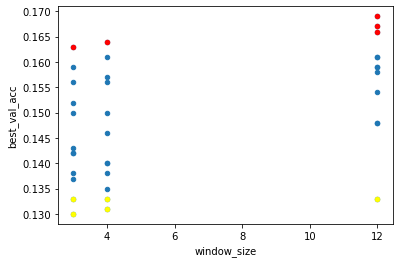

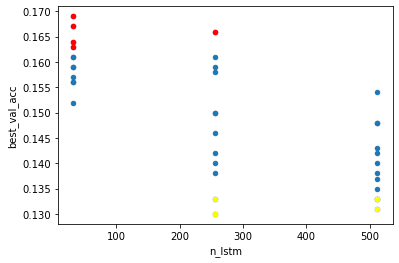

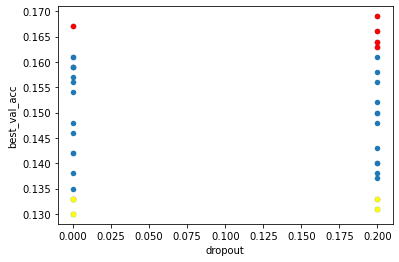

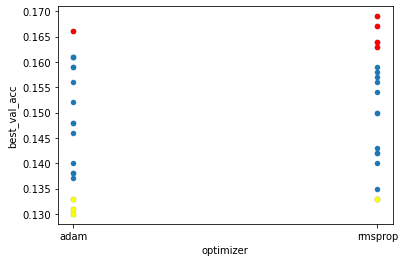

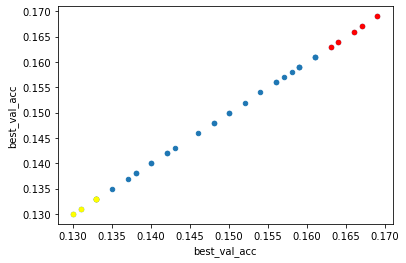

In [11]:
import matplotlib.pyplot as plt

for hyperparam in [ 'window_size', 'n_lstm', 'dropout', 'optimizer', 'best_val_acc']:
  ax1 = hyperas_log.plot(kind='scatter', x=hyperparam, y='best_val_acc')
  hyperas_best10.plot(kind='scatter', x=hyperparam, y='best_val_acc', color='red', ax=ax1)
  hyperas_worst10.plot(kind='scatter', x=hyperparam, y='best_val_acc', color='yellow', ax=ax1)


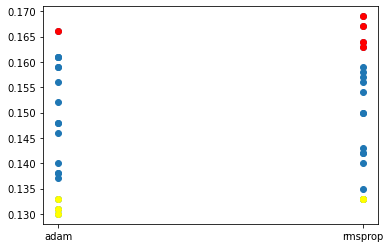

In [12]:
plt.scatter(hyperas_log.optimizer, hyperas_log.best_val_acc)
plt.scatter(hyperas_best10.optimizer, hyperas_best10.best_val_acc, color='red')
plt.scatter(hyperas_worst10.optimizer, hyperas_worst10.best_val_acc, color='yellow')
plt.show()

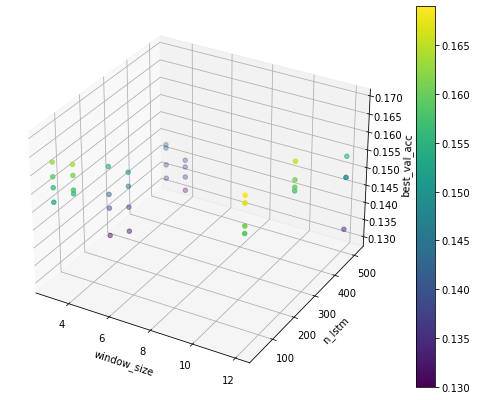

In [13]:
# How are the hyperparameters and the val_acc realated?
from mpl_toolkits.mplot3d import Axes3D
# Let's plot the relation of n_filters1 / n_filters2 and the best_val_acc
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(hyperas_log.window_size, hyperas_log.n_lstm, hyperas_log.best_val_acc, c=hyperas_log.best_val_acc)
ax.set_xlabel('window_size')
ax.set_ylabel('n_lstm')
ax.set_zlabel('best_val_acc')
fig.colorbar(p)
plt.show()

In [14]:
# Printing out the loss function
import matplotlib.pyplot as plt

for hist in hist_saved[:40]:
  plt.plot(hist.history['loss'])


In [15]:
# Printing out the loss function
import matplotlib.pyplot as plt

for hist in hist_saved[:40]:
  plt.plot(hist.history['val_accuracy'])

In [16]:
"""
for i in range(1):
  plt.plot( [np.argmax(value) for value in y_matrix_categorical_saved[i]] )

kappa = X_matrix_saved[1]
kappa.shape
for i in range(kappa.shape[0]):
  plt.plot(kappa[i, 1, :])

plt.plot( [ value in X_matrix_saved[:, 1, :]]
"""

'\nfor i in range(1):\n  plt.plot( [np.argmax(value) for value in y_matrix_categorical_saved[i]] )\n\nkappa = X_matrix_saved[1]\nkappa.shape\nfor i in range(kappa.shape[0]):\n  plt.plot(kappa[i, 1, :])\n\nplt.plot( [ value in X_matrix_saved[:, 1, :]]\n'

In [17]:
# This function return the vector form of the model output
# (First it converts it to index and the using indicies_words it 
# transformes the index to the vector form)
# Input: model_output
# Output: vector from of the model_output
def model_output_to_vector(model_output):
  szo = indicies_words[np.argmax(model_output)]
  vector = float_dictionary[szo]
  return vector

# This function deletes the first element of the input vector
# and appends a new element to the last position.
# We use this for text generation.
# Input: old_input, new_vector
# Output: new_input
def refresh_input(old_input, new_vector):
  new_input = np.zeros(old_input.shape)
  dim = old_input.shape[1]
  new_input[0,:(dim - 1), : ] = old_input[0, 1:dim, :]
  new_input[0, dim - 1, :] = new_vector
  return new_input


# mintavétel, ami újrasúlyozza a predikciót a temperature változó alapján 
# Function for sampling. It re-weights the prediction depending on the temperature variable
# Input: preds : the distribution to be re-weighted
#        temperature : changes the distribution. The heigher we set the value, the more it changes
#                      If we want to have a good impact, we encourage the user to set temperature >= 2
def sample(preds, temperature=2):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds) # Az összes lehetőség egyre szummázódjon (lásd softmax képlet)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas), preds




# This function generates text using the trained model.
# Input: input: the starting sequence
#        n_to_generate: this is how many words will be automatically generated 
#                       using "input" as starting sequence
# Output: text: the generated string
def word_generator(input, input_indicies = None, n_to_generate = 50):
  text = []
  text_indicies = []
  for i in range(n_to_generate):
    output = model.predict(input)
    output_arg, output = sample(output[0, :])
    output = np.asarray(output).astype('float32')
    output = output * 0
    output[output_arg] = 1
    # print(' Ezeknek kéne megegyezniük, de a tempearture miatt nem :) --> ', output_arg, np.argmax(output))
    text.append(indicies_words[np.argmax(output)])
    text_indicies.append(np.argmax(output))
    vector = model_output_to_vector(model_output = indicies_words[output_arg])
    new_input = refresh_input(old_input = input, new_vector = vector)
    input = new_input
  return text, text_indicies


"""
### --- Szöveg predikálás --- ###
"""
# Generating an input from the beginning of the corpus
input, _, input_indicies, _, _ = io_generator(index = 0,  window_size=window_size[-1])
# Feeding the input to the text generator & predicting a text sequence.
text, text_indicies = word_generator(input=input, input_indicies = input_indicies)

print(' A predikált text:', text)

AttributeError: 'list' object has no attribute 'predict'

In [ ]:
# Evaluating the performance on a specific input
input, _, input_indicies, y_indices, y_matrix_categorical = io_generator(index = 0,  window_size=window_size[-1], input_size=1000)
model.evaluate(x=input, y=y_matrix_categorical)